In [82]:
import numpy as np

class DenseLayer:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.bias = np.zeros((1, output_dim))
        self.input = None
        self.d_weights = None
        self.d_bias = None  

    def forward(self, X):
        self.input = X
        return np.dot(X, self.weights) + self.bias

    def backward(self, d_out, learning_rate):
        self.d_weights = np.dot(self.input.T, d_out)
        self.d_bias = np.sum(d_out, axis=0, keepdims=True)
        d_input = np.dot(d_out, self.weights.T)
        return d_input

In [83]:
class ReLU:
    def forward(self, X):
        self.input = X
        return np.maximum(0, X)

    def backward(self, d_out):
        return d_out * (self.input > 0)

In [84]:
class BatchNormalization:
    def __init__(self, dim, epsilon=1e-5, momentum=0.9):
        self.gamma = np.ones(dim)
        self.beta = np.zeros(dim)
        self.epsilon = epsilon
        self.momentum = momentum
        self.running_mean = np.zeros(dim)
        self.running_var = np.zeros(dim)
        self.input = None

    def forward(self, X, training=True):
        if training:
            self.mean = np.mean(X, axis=0)
            self.var = np.var(X, axis=0)
            self.input = X

            self.X_norm = (X - self.mean) / np.sqrt(self.var + self.epsilon)
            out = self.gamma * self.X_norm + self.beta

            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.var
        else:
            X_norm = (X - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
            out = self.gamma * X_norm + self.beta
        
        return out

    def backward(self, d_out, learning_rate):
        N, D = d_out.shape

        X_mu = self.input - self.mean
        std_inv = 1. / np.sqrt(self.var + self.epsilon)

        dX_norm = d_out * self.gamma
        dvar = np.sum(dX_norm * X_mu, axis=0) * -0.5 * std_inv**3
        dmean = np.sum(dX_norm * -std_inv, axis=0) + dvar * np.mean(-2. * X_mu, axis=0)

        dX = (dX_norm * std_inv) + (dvar * 2 * X_mu / N) + (dmean / N)
        self.gamma -= learning_rate * np.sum(d_out * self.X_norm, axis=0)
        self.beta -= learning_rate * np.sum(d_out, axis=0)
        
        return dX


In [85]:
class Dropout:
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate

    def forward(self, X, training=True):
        if training:
            self.mask = np.random.rand(*X.shape) > self.dropout_rate
            return X * self.mask / (1 - self.dropout_rate)
        else:
            return X

    def backward(self, d_out):
        return d_out * self.mask / (1 - self.dropout_rate)


In [86]:
class AdamOptimizer:
    def __init__(self, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0

    def update(self, params, grads):
        self.t += 1
        updated_params = {}

        for key in params:
            if key not in self.m:
                self.m[key] = [np.zeros_like(grads[key][0]),np.zeros_like(grads[key][1])]
                self.v[key] = [np.zeros_like(grads[key][0]),np.zeros_like(grads[key][1])]

            self.m[key][0] = self.beta1 * self.m[key][0] + (1 - self.beta1) * grads[key][0]
            self.m[key][1] = self.beta1 * self.m[key][1] + (1 - self.beta1) * grads[key][1]

            self.v[key][0] = self.beta2 * self.v[key][0] + (1 - self.beta2) * (grads[key][0] ** 2)
            self.v[key][1] = self.beta2 * self.v[key][1] + (1 - self.beta2) * (grads[key][1] ** 2)

            m_hat_weights = self.m[key][0] / (1 - self.beta1 ** self.t)
            m_hat_bias = self.m[key][1] / (1 - self.beta1 ** self.t)
            v_hat_weights = self.v[key][0] / (1 - self.beta2 ** self.t)
            v_hat_bias = self.v[key][1] / (1 - self.beta2 ** self.t)

            updated_params[key] =[params[key][0] - self.learning_rate * m_hat_weights / (np.sqrt(v_hat_weights) + self.epsilon),
                                    params[key][1] - self.learning_rate * m_hat_bias / (np.sqrt(v_hat_bias) + self.epsilon)]

        return updated_params



In [87]:
class Softmax:
    def forward(self, X):
        exps = np.exp(X - np.max(X, axis=1, keepdims=True))
        self.output = exps / np.sum(exps, axis=1, keepdims=True)
        return self.output

    def backward(self, d_out):
        return self.output * (d_out - np.sum(d_out * self.output, axis=1, keepdims=True))


In [88]:
class FeedForwardNeuralNetwork:
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        self.layers = []
        
        # Adding first Dense layer
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            self.layers.append(DenseLayer(prev_dim, hidden_dim))
            self.layers.append(BatchNormalization(hidden_dim))
            self.layers.append(ReLU())
            self.layers.append(Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Adding final Dense layer
        self.layers.append(DenseLayer(prev_dim, output_dim))
        self.layers.append(Softmax())

    def forward(self, X, training=True):
        # Forward pass through all layers
        for layer in self.layers:
            if isinstance(layer, (Dropout,BatchNormalization)):
                X = layer.forward(X, training)
            else:
                X = layer.forward(X)
        return X

    def backward(self, d_out, learning_rate):
        # Backward pass through all layers in reverse order
        for layer in reversed(self.layers):
            if isinstance(layer, (DenseLayer, BatchNormalization)):
                d_out = layer.backward(d_out, learning_rate)
            elif isinstance(layer, (ReLU, Dropout, Softmax)):
                d_out = layer.backward(d_out)

    def update_params(self, adam_optimizer):
        # Parameter and gradient dicts
        params = {}
        grads = {}
        
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                params[id(layer)] = [layer.weights,layer.bias]
                grads[id(layer)] = [layer.d_weights,layer.d_bias]
        
        # Updating parameters using Adam optimizer
        updated_params = adam_optimizer.update(params, grads)

        # Updating the layers with the new parameters
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                layer.weights = updated_params[id(layer)][0]
                layer.bias = updated_params[id(layer)][1]


In [89]:
from torchvision import datasets, transforms

# Define transformation
transform = transforms.ToTensor()

# Load the training dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

# Load the test dataset separately
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

In [90]:
import tqdm
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
np.random.seed(42)

class Model:
    def __init__(self,input_dim,hidden_dims,output_dim,dropout_rate,learning_rate,batch_size,num_epochs):
        # Hyperparameters
        self.input_dim = input_dim 
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim 
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.batch_size = batch_size 
        self.num_epochs = num_epochs

        # Initialize the fnn
        self.fnn = FeedForwardNeuralNetwork(self.input_dim, self.hidden_dims, self.output_dim, self.dropout_rate)
        self.adam_optimizer = AdamOptimizer(self.learning_rate)

    def fit(self,dataset,history,train):

        # Split the dataset for training and validation
        train_size = int(0.8 * len(dataset))  #!<-----------------------------------------------------------
        val_size = len(dataset) - train_size
        train_subset, val_subset = random_split(dataset, [train_size, val_size])

        # Create DataLoaders for training and validation subsets
        if train:
            train_loader = DataLoader(train_subset, batch_size=self.batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=self.batch_size, shuffle=False)
        else:
            train_loader = dataset

        # Training loop
        print(self.num_epochs)
        for epoch in range(self.num_epochs):
            epoch_loss = 0
            correct = 0
            total = 0

            for images, labels in tqdm.tqdm(train_loader):
                # Flatten images
                images = images.view(-1, 28 * 28).numpy()
                
                # Forward pass
                outputs = self.fnn.forward(images, training=True)
                
                # One-hot encoding for labels
                one_hot_labels = np.eye(self.output_dim)[labels.numpy()]

                # Compute loss (cross-entropy loss)
                loss = -np.sum(one_hot_labels * np.log(outputs + 1e-8)) / len(labels)
                epoch_loss += loss

                # Backward pass
                d_out = outputs - np.eye(self.output_dim)[labels.numpy()]
                self.fnn.backward(d_out, self.learning_rate)

                # Update parameters
                self.fnn.update_params(self.adam_optimizer)

                # Calculate accuracy
                predictions = np.argmax(outputs, axis=1)
                correct += (predictions == labels.numpy()).sum()
                total += labels.size(0)

            train_accuracy = correct / total
            history['train_loss'].append(epoch_loss / len(train_loader))
            history['train_acc'].append(train_accuracy)

            # Display epoch results
            print("total: ",total,"correct: ",correct)
            epoch_accuracy = correct / total
            print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {epoch_loss/ len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}')


            # Testing phase
            all_predictions = []
            all_true_labels = []

            correct = 0
            total = 0
            epoch_loss = 0
            
            if train:
                for images, labels in val_loader:
                    # Flatten images
                    images = images.view(-1, 28 * 28).numpy()

                    # Forward pass (inference mode)
                    outputs = self.fnn.forward(images, training=False)
                    predictions = np.argmax(outputs, axis=1)

                    # One-hot encoding for labels
                    one_hot_labels = np.eye(self.output_dim)[labels.numpy()]

                    # Compute loss (cross-entropy loss)
                    loss = -np.sum(one_hot_labels * np.log(outputs + 1e-8)) / len(labels)
                    #print(len(labels))
                    epoch_loss += loss

                    # Collect results
                    all_predictions.extend(predictions)
                    all_true_labels.extend(labels.numpy())

                    # Calculate accuracy
                    correct += (predictions == labels.numpy()).sum()
                    total += labels.size(0)
                    
                if epoch == self.num_epochs - 1:
                    conf_matrix = confusion_matrix(all_true_labels, all_predictions)
                    print("Confusion Matrix:")
                    print(conf_matrix)
                    history['confusion_mat'].append(conf_matrix)

            if train:
                # Calculate accuracy using sklearn
                accuracy = accuracy_score(all_true_labels, all_predictions)
                print(f'Validation Accuracy: {accuracy:.4f}')

                val_accuracy = correct / total
                val_f1 = f1_score(all_true_labels, all_predictions, average='macro')
                val_loss = epoch_loss / len(val_loader)
                history['val_loss'].append(val_loss)
                print(f'Validation loss: {val_loss:.4f}')
                history['val_acc'].append(val_accuracy)
                history['val_f1'].append(val_f1)
                print(f'Validation Macro F1: {val_f1:.4f}')

        return self.fnn

In [91]:
def Test(model,data):
    all_predictions = []
    all_labels = []
    for images, labels in data:
        # Flatten the images
        images = images.view(images.size(0), -1).numpy()

        # Forward pass through the loaded model
        outputs = model.forward(images)

        # Get the predicted class (highest probability)
        predictions = np.argmax(outputs, axis=1)

        # Collect predictions and true labels for accuracy computation
        all_predictions.extend(predictions)
        all_labels.extend(labels.numpy())

    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Step 4: Evaluate the model
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Hyperparamers

In [ ]:
input_dim = 28 * 28  # Image size (28x28)
output_dim = 10  # Number of classes (0-9)
dropout_rate = 0.2
batch_size = 64
num_epochs = 15

hidden_dims = [[512,256],[256,128],[128,64]]  # Hidden layers
learning_rates = [0.005,0.001,0.0005,0.0001]

histories = []
models = []

In [93]:
for hidden_dim in hidden_dims:
    for learning_rate in learning_rates:
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': [], 'model_info':[],'confusion_mat':[]}
        history['model_info'].append(hidden_dim)
        history['model_info'].append(learning_rate)
        model_current = Model(input_dim,hidden_dim,output_dim,dropout_rate,learning_rate,batch_size,num_epochs)
        model = model_current.fit(train_dataset,history,train=True)
        histories.append(history)
        models.append(model)
        
 

15


100%|██████████| 750/750 [00:35<00:00, 21.36it/s]


total:  48000 correct:  38960
Epoch [1/15], Loss: 0.5616, Accuracy: 0.8117
Validation Accuracy: 0.8403
Validation loss: 0.4976
Validation Macro F1: 0.8373


100%|██████████| 750/750 [00:34<00:00, 21.98it/s]


total:  48000 correct:  40836
Epoch [2/15], Loss: 0.4553, Accuracy: 0.8508
Validation Accuracy: 0.8482
Validation loss: 0.4388
Validation Macro F1: 0.8496


100%|██████████| 750/750 [00:33<00:00, 22.43it/s]


total:  48000 correct:  41330
Epoch [3/15], Loss: 0.4350, Accuracy: 0.8610
Validation Accuracy: 0.8742
Validation loss: 0.3741
Validation Macro F1: 0.8730


100%|██████████| 750/750 [00:33<00:00, 22.37it/s]


total:  48000 correct:  41819
Epoch [4/15], Loss: 0.4088, Accuracy: 0.8712
Validation Accuracy: 0.8772
Validation loss: 0.3789
Validation Macro F1: 0.8765


100%|██████████| 750/750 [00:34<00:00, 21.89it/s]


total:  48000 correct:  42033
Epoch [5/15], Loss: 0.3942, Accuracy: 0.8757
Validation Accuracy: 0.8829
Validation loss: 0.3731
Validation Macro F1: 0.8821


100%|██████████| 750/750 [00:33<00:00, 22.52it/s]


total:  48000 correct:  42277
Epoch [6/15], Loss: 0.3869, Accuracy: 0.8808
Validation Accuracy: 0.8812
Validation loss: 0.3684
Validation Macro F1: 0.8794


100%|██████████| 750/750 [00:33<00:00, 22.59it/s]


total:  48000 correct:  42469
Epoch [7/15], Loss: 0.3772, Accuracy: 0.8848
Validation Accuracy: 0.8912
Validation loss: 0.3452
Validation Macro F1: 0.8906


100%|██████████| 750/750 [00:33<00:00, 22.49it/s]


total:  48000 correct:  42708
Epoch [8/15], Loss: 0.3672, Accuracy: 0.8898
Validation Accuracy: 0.8899
Validation loss: 0.3693
Validation Macro F1: 0.8897


100%|██████████| 750/750 [00:31<00:00, 23.45it/s]


total:  48000 correct:  42880
Epoch [9/15], Loss: 0.3607, Accuracy: 0.8933
Validation Accuracy: 0.8788
Validation loss: 0.4197
Validation Macro F1: 0.8761


100%|██████████| 750/750 [00:30<00:00, 24.49it/s]


total:  48000 correct:  43030
Epoch [10/15], Loss: 0.3583, Accuracy: 0.8965
Validation Accuracy: 0.8924
Validation loss: 0.3493
Validation Macro F1: 0.8924


100%|██████████| 750/750 [00:30<00:00, 24.50it/s]


total:  48000 correct:  43155
Epoch [11/15], Loss: 0.3486, Accuracy: 0.8991
Validation Accuracy: 0.8932
Validation loss: 0.3567
Validation Macro F1: 0.8931


100%|██████████| 750/750 [00:30<00:00, 24.75it/s]


total:  48000 correct:  43292
Epoch [12/15], Loss: 0.3416, Accuracy: 0.9019
Validation Accuracy: 0.8794
Validation loss: 0.4110
Validation Macro F1: 0.8810


100%|██████████| 750/750 [00:30<00:00, 24.77it/s]


total:  48000 correct:  43347
Epoch [13/15], Loss: 0.3375, Accuracy: 0.9031
Validation Accuracy: 0.8942
Validation loss: 0.3692
Validation Macro F1: 0.8932


100%|██████████| 750/750 [00:30<00:00, 24.64it/s]


total:  48000 correct:  43540
Epoch [14/15], Loss: 0.3299, Accuracy: 0.9071
Validation Accuracy: 0.8891
Validation loss: 0.3651
Validation Macro F1: 0.8884


100%|██████████| 750/750 [00:30<00:00, 24.60it/s]


total:  48000 correct:  43620
Epoch [15/15], Loss: 0.3157, Accuracy: 0.9087
Confusion Matrix:
[[1057    0   17   21    1    2  116    2    7    0]
 [   4 1192    2   22    0    1    1    0    0    0]
 [  17    0 1049   10   57    1   50    0    3    0]
 [  44    4   11 1042   29    3   18    0    3    0]
 [   5    0  136   40  988    1   48    1    2    0]
 [   0    0    0    0    0 1172    0   34    2   19]
 [ 144    3  119   18   79    0  825    1    9    0]
 [   0    0    0    0    0   25    0 1152    1   24]
 [   3    1    9    8    1   12    8    1 1119    2]
 [   0    0    0    0    0    5    0   55    1 1141]]
Validation Accuracy: 0.8948
Validation loss: 0.3534
Validation Macro F1: 0.8943
15


100%|██████████| 750/750 [00:30<00:00, 24.60it/s]


total:  48000 correct:  39368
Epoch [1/15], Loss: 0.5355, Accuracy: 0.8202
Validation Accuracy: 0.8592
Validation loss: 0.3949
Validation Macro F1: 0.8590


100%|██████████| 750/750 [00:30<00:00, 24.75it/s]


total:  48000 correct:  41210
Epoch [2/15], Loss: 0.4120, Accuracy: 0.8585
Validation Accuracy: 0.8714
Validation loss: 0.3652
Validation Macro F1: 0.8696


100%|██████████| 750/750 [00:30<00:00, 24.27it/s]


total:  48000 correct:  41768
Epoch [3/15], Loss: 0.3733, Accuracy: 0.8702
Validation Accuracy: 0.8767
Validation loss: 0.3491
Validation Macro F1: 0.8777


100%|██████████| 750/750 [00:31<00:00, 24.11it/s]


total:  48000 correct:  42168
Epoch [4/15], Loss: 0.3504, Accuracy: 0.8785
Validation Accuracy: 0.8755
Validation loss: 0.3517
Validation Macro F1: 0.8745


100%|██████████| 750/750 [00:31<00:00, 23.46it/s]


total:  48000 correct:  42474
Epoch [5/15], Loss: 0.3345, Accuracy: 0.8849
Validation Accuracy: 0.8802
Validation loss: 0.3318
Validation Macro F1: 0.8808


100%|██████████| 750/750 [00:31<00:00, 23.65it/s]


total:  48000 correct:  42764
Epoch [6/15], Loss: 0.3256, Accuracy: 0.8909
Validation Accuracy: 0.8887
Validation loss: 0.3172
Validation Macro F1: 0.8876


100%|██████████| 750/750 [00:31<00:00, 23.45it/s]


total:  48000 correct:  42964
Epoch [7/15], Loss: 0.3119, Accuracy: 0.8951
Validation Accuracy: 0.8865
Validation loss: 0.3272
Validation Macro F1: 0.8853


100%|██████████| 750/750 [00:30<00:00, 24.43it/s]


total:  48000 correct:  43137
Epoch [8/15], Loss: 0.3027, Accuracy: 0.8987
Validation Accuracy: 0.8898
Validation loss: 0.3106
Validation Macro F1: 0.8894


100%|██████████| 750/750 [00:31<00:00, 23.96it/s]


total:  48000 correct:  43318
Epoch [9/15], Loss: 0.2942, Accuracy: 0.9025
Validation Accuracy: 0.8911
Validation loss: 0.3207
Validation Macro F1: 0.8899


100%|██████████| 750/750 [00:31<00:00, 23.73it/s]


total:  48000 correct:  43427
Epoch [10/15], Loss: 0.2904, Accuracy: 0.9047
Validation Accuracy: 0.8882
Validation loss: 0.3311
Validation Macro F1: 0.8860


100%|██████████| 750/750 [00:31<00:00, 23.84it/s]


total:  48000 correct:  43600
Epoch [11/15], Loss: 0.2805, Accuracy: 0.9083
Validation Accuracy: 0.8964
Validation loss: 0.3034
Validation Macro F1: 0.8956


100%|██████████| 750/750 [00:31<00:00, 24.17it/s]


total:  48000 correct:  43728
Epoch [12/15], Loss: 0.2761, Accuracy: 0.9110
Validation Accuracy: 0.8902
Validation loss: 0.3138
Validation Macro F1: 0.8908


100%|██████████| 750/750 [00:30<00:00, 24.48it/s]


total:  48000 correct:  43889
Epoch [13/15], Loss: 0.2700, Accuracy: 0.9144
Validation Accuracy: 0.8909
Validation loss: 0.3206
Validation Macro F1: 0.8899


100%|██████████| 750/750 [00:30<00:00, 24.41it/s]


total:  48000 correct:  43941
Epoch [14/15], Loss: 0.2653, Accuracy: 0.9154
Validation Accuracy: 0.8953
Validation loss: 0.3054
Validation Macro F1: 0.8960


100%|██████████| 750/750 [00:30<00:00, 24.50it/s]


total:  48000 correct:  44108
Epoch [15/15], Loss: 0.2568, Accuracy: 0.9189
Confusion Matrix:
[[1044    6   15   29    5    0   81    0    8    0]
 [   1 1135    1   15    4    0    1    0    0    0]
 [  18    0  934   10  150    0   45    0    9    0]
 [  18    4   11 1141   34    0   14    0    2    1]
 [   0    0   53   34 1040    0   36    0    5    0]
 [   0    0    0    0    0 1130    0   42    4   13]
 [ 167    2   98   33  115    0  811    0   12    0]
 [   0    0    0    0    0   11    0 1211    2   22]
 [   4    1    1    5    4    2    7    2 1205    0]
 [   0    1    0    0    0    9    0   52    2 1128]]
Validation Accuracy: 0.8982
Validation loss: 0.3006
Validation Macro F1: 0.8971
15


100%|██████████| 750/750 [00:30<00:00, 24.77it/s]


total:  48000 correct:  39522
Epoch [1/15], Loss: 0.5563, Accuracy: 0.8234
Validation Accuracy: 0.8614
Validation loss: 0.4014
Validation Macro F1: 0.8593


100%|██████████| 750/750 [00:30<00:00, 24.66it/s]


total:  48000 correct:  41333
Epoch [2/15], Loss: 0.4049, Accuracy: 0.8611
Validation Accuracy: 0.8708
Validation loss: 0.3654
Validation Macro F1: 0.8692


100%|██████████| 750/750 [00:30<00:00, 24.70it/s]


total:  48000 correct:  41964
Epoch [3/15], Loss: 0.3676, Accuracy: 0.8742
Validation Accuracy: 0.8788
Validation loss: 0.3445
Validation Macro F1: 0.8782


100%|██████████| 750/750 [00:30<00:00, 24.77it/s]


total:  48000 correct:  42290
Epoch [4/15], Loss: 0.3468, Accuracy: 0.8810
Validation Accuracy: 0.8799
Validation loss: 0.3407
Validation Macro F1: 0.8811


100%|██████████| 750/750 [00:30<00:00, 24.60it/s]


total:  48000 correct:  42586
Epoch [5/15], Loss: 0.3320, Accuracy: 0.8872
Validation Accuracy: 0.8832
Validation loss: 0.3312
Validation Macro F1: 0.8828


100%|██████████| 750/750 [00:32<00:00, 22.80it/s]


total:  48000 correct:  42848
Epoch [6/15], Loss: 0.3160, Accuracy: 0.8927
Validation Accuracy: 0.8812
Validation loss: 0.3296
Validation Macro F1: 0.8808


100%|██████████| 750/750 [00:30<00:00, 24.64it/s]


total:  48000 correct:  43075
Epoch [7/15], Loss: 0.3075, Accuracy: 0.8974
Validation Accuracy: 0.8942
Validation loss: 0.3091
Validation Macro F1: 0.8937


100%|██████████| 750/750 [00:30<00:00, 24.62it/s]


total:  48000 correct:  43277
Epoch [8/15], Loss: 0.2936, Accuracy: 0.9016
Validation Accuracy: 0.8914
Validation loss: 0.3108
Validation Macro F1: 0.8914


100%|██████████| 750/750 [00:30<00:00, 24.60it/s]


total:  48000 correct:  43432
Epoch [9/15], Loss: 0.2889, Accuracy: 0.9048
Validation Accuracy: 0.8941
Validation loss: 0.3123
Validation Macro F1: 0.8934


100%|██████████| 750/750 [00:30<00:00, 24.48it/s]


total:  48000 correct:  43513
Epoch [10/15], Loss: 0.2789, Accuracy: 0.9065
Validation Accuracy: 0.8876
Validation loss: 0.3201
Validation Macro F1: 0.8888


100%|██████████| 750/750 [00:30<00:00, 24.65it/s]


total:  48000 correct:  43763
Epoch [11/15], Loss: 0.2711, Accuracy: 0.9117
Validation Accuracy: 0.8846
Validation loss: 0.3189
Validation Macro F1: 0.8852


100%|██████████| 750/750 [00:30<00:00, 24.53it/s]


total:  48000 correct:  43790
Epoch [12/15], Loss: 0.2649, Accuracy: 0.9123
Validation Accuracy: 0.8997
Validation loss: 0.2932
Validation Macro F1: 0.9001


100%|██████████| 750/750 [00:30<00:00, 24.83it/s]


total:  48000 correct:  43956
Epoch [13/15], Loss: 0.2622, Accuracy: 0.9157
Validation Accuracy: 0.9019
Validation loss: 0.2978
Validation Macro F1: 0.9018


100%|██████████| 750/750 [00:30<00:00, 24.63it/s]


total:  48000 correct:  44040
Epoch [14/15], Loss: 0.2536, Accuracy: 0.9175
Validation Accuracy: 0.8978
Validation loss: 0.3156
Validation Macro F1: 0.8963


100%|██████████| 750/750 [00:30<00:00, 24.75it/s]


total:  48000 correct:  44250
Epoch [15/15], Loss: 0.2455, Accuracy: 0.9219
Confusion Matrix:
[[ 985    1   21   60    7    3  135    0    3    0]
 [   0 1151    2   18    5    0    0    0    3    0]
 [  15    0 1021   11  144    1   33    0    2    0]
 [   9    2    8 1059   38    0   17    0    1    0]
 [   1    1   48   31 1107    0   32    0    4    0]
 [   0    0    0    1    0 1178    0   37    3    4]
 [ 120    1  116   35  120    0  784    0   12    0]
 [   0    0    0    0    0   17    0 1202    0   25]
 [   4    0    6    6    2    2   10    2 1119    0]
 [   0    0    0    1    0   12    0   34    2 1166]]
Validation Accuracy: 0.8977
Validation loss: 0.3046
Validation Macro F1: 0.8969
15


100%|██████████| 750/750 [00:30<00:00, 24.53it/s]


total:  48000 correct:  38597
Epoch [1/15], Loss: 0.7510, Accuracy: 0.8041
Validation Accuracy: 0.8479
Validation loss: 0.4774
Validation Macro F1: 0.8403


100%|██████████| 750/750 [00:30<00:00, 24.50it/s]


total:  48000 correct:  41442
Epoch [2/15], Loss: 0.4350, Accuracy: 0.8634
Validation Accuracy: 0.8702
Validation loss: 0.3874
Validation Macro F1: 0.8691


100%|██████████| 750/750 [00:30<00:00, 24.39it/s]


total:  48000 correct:  42042
Epoch [3/15], Loss: 0.3834, Accuracy: 0.8759
Validation Accuracy: 0.8824
Validation loss: 0.3548
Validation Macro F1: 0.8814


100%|██████████| 750/750 [00:30<00:00, 24.48it/s]


total:  48000 correct:  42508
Epoch [4/15], Loss: 0.3531, Accuracy: 0.8856
Validation Accuracy: 0.8820
Validation loss: 0.3510
Validation Macro F1: 0.8813


100%|██████████| 750/750 [00:30<00:00, 24.32it/s]


total:  48000 correct:  42822
Epoch [5/15], Loss: 0.3289, Accuracy: 0.8921
Validation Accuracy: 0.8767
Validation loss: 0.3604
Validation Macro F1: 0.8770


100%|██████████| 750/750 [00:30<00:00, 24.64it/s]


total:  48000 correct:  43079
Epoch [6/15], Loss: 0.3140, Accuracy: 0.8975
Validation Accuracy: 0.8801
Validation loss: 0.3449
Validation Macro F1: 0.8785


100%|██████████| 750/750 [00:30<00:00, 24.31it/s]


total:  48000 correct:  43258
Epoch [7/15], Loss: 0.3034, Accuracy: 0.9012
Validation Accuracy: 0.8894
Validation loss: 0.3224
Validation Macro F1: 0.8883


100%|██████████| 750/750 [00:30<00:00, 24.65it/s]


total:  48000 correct:  43454
Epoch [8/15], Loss: 0.2918, Accuracy: 0.9053
Validation Accuracy: 0.8889
Validation loss: 0.3223
Validation Macro F1: 0.8872


100%|██████████| 750/750 [00:36<00:00, 20.62it/s]


total:  48000 correct:  43671
Epoch [9/15], Loss: 0.2774, Accuracy: 0.9098
Validation Accuracy: 0.8870
Validation loss: 0.3233
Validation Macro F1: 0.8855


100%|██████████| 750/750 [00:38<00:00, 19.44it/s]


total:  48000 correct:  43794
Epoch [10/15], Loss: 0.2711, Accuracy: 0.9124
Validation Accuracy: 0.8930
Validation loss: 0.3111
Validation Macro F1: 0.8910


100%|██████████| 750/750 [00:34<00:00, 21.79it/s]


total:  48000 correct:  43971
Epoch [11/15], Loss: 0.2615, Accuracy: 0.9161
Validation Accuracy: 0.8891
Validation loss: 0.3169
Validation Macro F1: 0.8879


100%|██████████| 750/750 [00:35<00:00, 21.15it/s]


total:  48000 correct:  44126
Epoch [12/15], Loss: 0.2535, Accuracy: 0.9193
Validation Accuracy: 0.8911
Validation loss: 0.3122
Validation Macro F1: 0.8879


100%|██████████| 750/750 [00:52<00:00, 14.29it/s]


total:  48000 correct:  44201
Epoch [13/15], Loss: 0.2488, Accuracy: 0.9209
Validation Accuracy: 0.8970
Validation loss: 0.3007
Validation Macro F1: 0.8960


100%|██████████| 750/750 [00:41<00:00, 17.86it/s]


total:  48000 correct:  44288
Epoch [14/15], Loss: 0.2437, Accuracy: 0.9227
Validation Accuracy: 0.8915
Validation loss: 0.3091
Validation Macro F1: 0.8912


100%|██████████| 750/750 [00:42<00:00, 17.67it/s]


total:  48000 correct:  44361
Epoch [15/15], Loss: 0.2385, Accuracy: 0.9242
Confusion Matrix:
[[1052    1   16   21    2    0   60    0    4    0]
 [   7 1184    2   17    1    0    2    0    0    0]
 [  29    0 1030   12   90    0   49    0    5    0]
 [  51    5    9 1093   50    0   22    0    4    0]
 [   4    2  105   35 1007    0   49    0    6    0]
 [   0    0    0    1    0 1157    0   20    1    7]
 [ 197    2   89   21   82    0  760    0   13    0]
 [   0    0    0    0    0   20    0 1206    1   24]
 [   5    0    7    1    2    0   13    3 1197    0]
 [   0    0    0    0    0   11    0   47    3 1084]]
Validation Accuracy: 0.8975
Validation loss: 0.2980
Validation Macro F1: 0.8959
15


100%|██████████| 750/750 [00:22<00:00, 33.85it/s]


total:  48000 correct:  39037
Epoch [1/15], Loss: 0.5516, Accuracy: 0.8133
Validation Accuracy: 0.8436
Validation loss: 0.4379
Validation Macro F1: 0.8449


100%|██████████| 750/750 [00:25<00:00, 29.18it/s]


total:  48000 correct:  40803
Epoch [2/15], Loss: 0.4471, Accuracy: 0.8501
Validation Accuracy: 0.8607
Validation loss: 0.4086
Validation Macro F1: 0.8595


100%|██████████| 750/750 [00:28<00:00, 26.61it/s]


total:  48000 correct:  41360
Epoch [3/15], Loss: 0.4092, Accuracy: 0.8617
Validation Accuracy: 0.8738
Validation loss: 0.3653
Validation Macro F1: 0.8727


100%|██████████| 750/750 [00:20<00:00, 35.79it/s]


total:  48000 correct:  41775
Epoch [4/15], Loss: 0.3882, Accuracy: 0.8703
Validation Accuracy: 0.8743
Validation loss: 0.3666
Validation Macro F1: 0.8747


100%|██████████| 750/750 [00:24<00:00, 30.44it/s]


total:  48000 correct:  42027
Epoch [5/15], Loss: 0.3777, Accuracy: 0.8756
Validation Accuracy: 0.8713
Validation loss: 0.3676
Validation Macro F1: 0.8714


100%|██████████| 750/750 [00:30<00:00, 24.68it/s]


total:  48000 correct:  42341
Epoch [6/15], Loss: 0.3646, Accuracy: 0.8821
Validation Accuracy: 0.8768
Validation loss: 0.3631
Validation Macro F1: 0.8770


100%|██████████| 750/750 [00:22<00:00, 33.47it/s]


total:  48000 correct:  42432
Epoch [7/15], Loss: 0.3569, Accuracy: 0.8840
Validation Accuracy: 0.8858
Validation loss: 0.3447
Validation Macro F1: 0.8851


100%|██████████| 750/750 [00:24<00:00, 31.02it/s]


total:  48000 correct:  42559
Epoch [8/15], Loss: 0.3484, Accuracy: 0.8866
Validation Accuracy: 0.8876
Validation loss: 0.3428
Validation Macro F1: 0.8875


100%|██████████| 750/750 [00:19<00:00, 38.06it/s]


total:  48000 correct:  42810
Epoch [9/15], Loss: 0.3388, Accuracy: 0.8919
Validation Accuracy: 0.8908
Validation loss: 0.3270
Validation Macro F1: 0.8899


100%|██████████| 750/750 [00:17<00:00, 41.72it/s]


total:  48000 correct:  42967
Epoch [10/15], Loss: 0.3294, Accuracy: 0.8951
Validation Accuracy: 0.8925
Validation loss: 0.3256
Validation Macro F1: 0.8920


100%|██████████| 750/750 [00:20<00:00, 36.60it/s]


total:  48000 correct:  43070
Epoch [11/15], Loss: 0.3238, Accuracy: 0.8973
Validation Accuracy: 0.8942
Validation loss: 0.3364
Validation Macro F1: 0.8933


100%|██████████| 750/750 [00:16<00:00, 44.78it/s]


total:  48000 correct:  43187
Epoch [12/15], Loss: 0.3191, Accuracy: 0.8997
Validation Accuracy: 0.8843
Validation loss: 0.3698
Validation Macro F1: 0.8831


100%|██████████| 750/750 [00:17<00:00, 43.65it/s]


total:  48000 correct:  43257
Epoch [13/15], Loss: 0.3130, Accuracy: 0.9012
Validation Accuracy: 0.8933
Validation loss: 0.3376
Validation Macro F1: 0.8932


100%|██████████| 750/750 [00:18<00:00, 40.89it/s]


total:  48000 correct:  43440
Epoch [14/15], Loss: 0.3117, Accuracy: 0.9050
Validation Accuracy: 0.8907
Validation loss: 0.3405
Validation Macro F1: 0.8917


100%|██████████| 750/750 [00:16<00:00, 46.08it/s]


total:  48000 correct:  43538
Epoch [15/15], Loss: 0.3067, Accuracy: 0.9070
Confusion Matrix:
[[ 996    1   10   20    3    3  144    0    8    0]
 [   3 1146    0   23    1    0    3    0    1    0]
 [  16    0  880    9   94    0  203    0    4    0]
 [  35    1    8 1063   20    0   21    0    0    0]
 [   1    0   67   30  963    0  134    0    8    0]
 [   0    0    0    1    0 1164    0   30    5    3]
 [ 128    1   32   35   37    0  971    0    5    0]
 [   0    0    0    0    0   20    0 1178    2   25]
 [   0    0    4    6    4    0   18    3 1186    0]
 [   0    0    0    0    0   21    0   46    3 1153]]
Validation Accuracy: 0.8917
Validation loss: 0.3361
Validation Macro F1: 0.8928
15


100%|██████████| 750/750 [00:16<00:00, 44.96it/s]


total:  48000 correct:  39030
Epoch [1/15], Loss: 0.5930, Accuracy: 0.8131
Validation Accuracy: 0.8565
Validation loss: 0.4187
Validation Macro F1: 0.8557


100%|██████████| 750/750 [00:16<00:00, 46.16it/s]


total:  48000 correct:  41125
Epoch [2/15], Loss: 0.4240, Accuracy: 0.8568
Validation Accuracy: 0.8738
Validation loss: 0.3670
Validation Macro F1: 0.8724


100%|██████████| 750/750 [00:17<00:00, 43.69it/s]


total:  48000 correct:  41621
Epoch [3/15], Loss: 0.3931, Accuracy: 0.8671
Validation Accuracy: 0.8753
Validation loss: 0.3516
Validation Macro F1: 0.8721


100%|██████████| 750/750 [00:20<00:00, 35.79it/s]


total:  48000 correct:  42041
Epoch [4/15], Loss: 0.3693, Accuracy: 0.8759
Validation Accuracy: 0.8699
Validation loss: 0.3618
Validation Macro F1: 0.8700


100%|██████████| 750/750 [00:18<00:00, 39.65it/s]


total:  48000 correct:  42277
Epoch [5/15], Loss: 0.3528, Accuracy: 0.8808
Validation Accuracy: 0.8853
Validation loss: 0.3278
Validation Macro F1: 0.8837


100%|██████████| 750/750 [00:18<00:00, 40.15it/s]


total:  48000 correct:  42530
Epoch [6/15], Loss: 0.3426, Accuracy: 0.8860
Validation Accuracy: 0.8819
Validation loss: 0.3326
Validation Macro F1: 0.8827


100%|██████████| 750/750 [00:18<00:00, 40.40it/s]


total:  48000 correct:  42734
Epoch [7/15], Loss: 0.3289, Accuracy: 0.8903
Validation Accuracy: 0.8892
Validation loss: 0.3184
Validation Macro F1: 0.8876


100%|██████████| 750/750 [00:18<00:00, 39.77it/s]


total:  48000 correct:  42952
Epoch [8/15], Loss: 0.3210, Accuracy: 0.8948
Validation Accuracy: 0.8910
Validation loss: 0.3129
Validation Macro F1: 0.8896


100%|██████████| 750/750 [00:18<00:00, 40.51it/s]


total:  48000 correct:  43030
Epoch [9/15], Loss: 0.3154, Accuracy: 0.8965
Validation Accuracy: 0.8906
Validation loss: 0.3158
Validation Macro F1: 0.8880


100%|██████████| 750/750 [00:18<00:00, 40.20it/s]


total:  48000 correct:  43164
Epoch [10/15], Loss: 0.3056, Accuracy: 0.8992
Validation Accuracy: 0.8924
Validation loss: 0.3094
Validation Macro F1: 0.8917


100%|██████████| 750/750 [00:18<00:00, 39.97it/s]


total:  48000 correct:  43242
Epoch [11/15], Loss: 0.3018, Accuracy: 0.9009
Validation Accuracy: 0.8883
Validation loss: 0.3103
Validation Macro F1: 0.8877


100%|██████████| 750/750 [00:18<00:00, 40.23it/s]


total:  48000 correct:  43325
Epoch [12/15], Loss: 0.2952, Accuracy: 0.9026
Validation Accuracy: 0.8998
Validation loss: 0.2941
Validation Macro F1: 0.8985


100%|██████████| 750/750 [00:19<00:00, 38.33it/s]


total:  48000 correct:  43443
Epoch [13/15], Loss: 0.2886, Accuracy: 0.9051
Validation Accuracy: 0.8988
Validation loss: 0.2968
Validation Macro F1: 0.8973


100%|██████████| 750/750 [00:19<00:00, 37.72it/s]


total:  48000 correct:  43624
Epoch [14/15], Loss: 0.2808, Accuracy: 0.9088
Validation Accuracy: 0.8909
Validation loss: 0.3124
Validation Macro F1: 0.8877


100%|██████████| 750/750 [00:19<00:00, 37.68it/s]


total:  48000 correct:  43657
Epoch [15/15], Loss: 0.2815, Accuracy: 0.9095
Confusion Matrix:
[[ 920    1    8   26    6    1  190    0    9    0]
 [   3 1153    0   25    5    0    3    0    1    0]
 [   9    1  836    6  231    4  123    0    4    0]
 [  24    0    5 1062   43    1   42    0    1    0]
 [   0    0   36   27 1099    1   44    0    4    0]
 [   1    0    0    0    0 1217    0   25    3   14]
 [  78    0   44   21  129    0  877    0   11    0]
 [   0    0    0    0    0   20    0 1136    1   34]
 [   4    0    2    2    4    4    7    2 1184    2]
 [   0    0    0    0    0   10    0   43    0 1171]]
Validation Accuracy: 0.8879
Validation loss: 0.3215
Validation Macro F1: 0.8874
15


100%|██████████| 750/750 [00:19<00:00, 38.98it/s]


total:  48000 correct:  38644
Epoch [1/15], Loss: 0.6578, Accuracy: 0.8051
Validation Accuracy: 0.8586
Validation loss: 0.4287
Validation Macro F1: 0.8578


100%|██████████| 750/750 [00:19<00:00, 39.10it/s]


total:  48000 correct:  41100
Epoch [2/15], Loss: 0.4306, Accuracy: 0.8562
Validation Accuracy: 0.8617
Validation loss: 0.4018
Validation Macro F1: 0.8566


100%|██████████| 750/750 [00:19<00:00, 39.34it/s]


total:  48000 correct:  41676
Epoch [3/15], Loss: 0.3931, Accuracy: 0.8682
Validation Accuracy: 0.8743
Validation loss: 0.3624
Validation Macro F1: 0.8739


100%|██████████| 750/750 [00:18<00:00, 40.06it/s]


total:  48000 correct:  42065
Epoch [4/15], Loss: 0.3690, Accuracy: 0.8764
Validation Accuracy: 0.8817
Validation loss: 0.3436
Validation Macro F1: 0.8814


100%|██████████| 750/750 [00:18<00:00, 40.28it/s]


total:  48000 correct:  42357
Epoch [5/15], Loss: 0.3515, Accuracy: 0.8824
Validation Accuracy: 0.8800
Validation loss: 0.3486
Validation Macro F1: 0.8792


100%|██████████| 750/750 [00:18<00:00, 39.98it/s]


total:  48000 correct:  42550
Epoch [6/15], Loss: 0.3389, Accuracy: 0.8865
Validation Accuracy: 0.8781
Validation loss: 0.3429
Validation Macro F1: 0.8771


100%|██████████| 750/750 [00:18<00:00, 39.51it/s]


total:  48000 correct:  42663
Epoch [7/15], Loss: 0.3278, Accuracy: 0.8888
Validation Accuracy: 0.8900
Validation loss: 0.3205
Validation Macro F1: 0.8902


100%|██████████| 750/750 [00:18<00:00, 40.57it/s]


total:  48000 correct:  42886
Epoch [8/15], Loss: 0.3154, Accuracy: 0.8935
Validation Accuracy: 0.8920
Validation loss: 0.3081
Validation Macro F1: 0.8918


100%|██████████| 750/750 [00:18<00:00, 40.25it/s]


total:  48000 correct:  43102
Epoch [9/15], Loss: 0.3097, Accuracy: 0.8980
Validation Accuracy: 0.8912
Validation loss: 0.3128
Validation Macro F1: 0.8904


100%|██████████| 750/750 [00:19<00:00, 37.58it/s]


total:  48000 correct:  43216
Epoch [10/15], Loss: 0.3033, Accuracy: 0.9003
Validation Accuracy: 0.8852
Validation loss: 0.3248
Validation Macro F1: 0.8846


100%|██████████| 750/750 [00:19<00:00, 37.55it/s]


total:  48000 correct:  43381
Epoch [11/15], Loss: 0.2936, Accuracy: 0.9038
Validation Accuracy: 0.8878
Validation loss: 0.3162
Validation Macro F1: 0.8890


100%|██████████| 750/750 [00:18<00:00, 40.85it/s]


total:  48000 correct:  43405
Epoch [12/15], Loss: 0.2918, Accuracy: 0.9043
Validation Accuracy: 0.8939
Validation loss: 0.3026
Validation Macro F1: 0.8932


100%|██████████| 750/750 [00:18<00:00, 40.36it/s]


total:  48000 correct:  43563
Epoch [13/15], Loss: 0.2828, Accuracy: 0.9076
Validation Accuracy: 0.8882
Validation loss: 0.3151
Validation Macro F1: 0.8892


100%|██████████| 750/750 [00:18<00:00, 40.32it/s]


total:  48000 correct:  43649
Epoch [14/15], Loss: 0.2810, Accuracy: 0.9094
Validation Accuracy: 0.8916
Validation loss: 0.3183
Validation Macro F1: 0.8907


100%|██████████| 750/750 [00:18<00:00, 40.82it/s]


total:  48000 correct:  43698
Epoch [15/15], Loss: 0.2753, Accuracy: 0.9104
Confusion Matrix:
[[1042    0   16   19    0    2  144    0    9    0]
 [   3 1159    2   12    2    0    4    0    0    0]
 [  17    2  940   12   78    0  183    0    4    0]
 [  26    7    8 1090   43    0   43    0    1    0]
 [   1    1   66   24  921    0  176    0    1    0]
 [   0    0    0    0    0 1165    1   19    4   11]
 [ 125    2   61   24   35    0  923    0    4    1]
 [   0    0    0    0    0   25    0 1165    2   31]
 [   6    2    5    5    0    2   16    5 1143    0]
 [   1    0    0    0    0   11    0   36    1 1111]]
Validation Accuracy: 0.8882
Validation loss: 0.3177
Validation Macro F1: 0.8903
15


100%|██████████| 750/750 [00:18<00:00, 41.21it/s]


total:  48000 correct:  36874
Epoch [1/15], Loss: 1.0637, Accuracy: 0.7682
Validation Accuracy: 0.8252
Validation loss: 0.6112
Validation Macro F1: 0.8128


100%|██████████| 750/750 [00:19<00:00, 39.22it/s]


total:  48000 correct:  40590
Epoch [2/15], Loss: 0.5486, Accuracy: 0.8456
Validation Accuracy: 0.8616
Validation loss: 0.4532
Validation Macro F1: 0.8592


100%|██████████| 750/750 [00:18<00:00, 40.56it/s]


total:  48000 correct:  41545
Epoch [3/15], Loss: 0.4507, Accuracy: 0.8655
Validation Accuracy: 0.8748
Validation loss: 0.3916
Validation Macro F1: 0.8737


100%|██████████| 750/750 [00:18<00:00, 39.59it/s]


total:  48000 correct:  41921
Epoch [4/15], Loss: 0.4064, Accuracy: 0.8734
Validation Accuracy: 0.8728
Validation loss: 0.3795
Validation Macro F1: 0.8716


100%|██████████| 750/750 [00:18<00:00, 40.88it/s]


total:  48000 correct:  42286
Epoch [5/15], Loss: 0.3809, Accuracy: 0.8810
Validation Accuracy: 0.8838
Validation loss: 0.3511
Validation Macro F1: 0.8823


100%|██████████| 750/750 [00:18<00:00, 40.15it/s]


total:  48000 correct:  42470
Epoch [6/15], Loss: 0.3626, Accuracy: 0.8848
Validation Accuracy: 0.8896
Validation loss: 0.3340
Validation Macro F1: 0.8885


100%|██████████| 750/750 [00:18<00:00, 39.63it/s]


total:  48000 correct:  42728
Epoch [7/15], Loss: 0.3445, Accuracy: 0.8902
Validation Accuracy: 0.8911
Validation loss: 0.3261
Validation Macro F1: 0.8901


100%|██████████| 750/750 [00:19<00:00, 39.33it/s]


total:  48000 correct:  42862
Epoch [8/15], Loss: 0.3361, Accuracy: 0.8930
Validation Accuracy: 0.8872
Validation loss: 0.3261
Validation Macro F1: 0.8857


100%|██████████| 750/750 [00:18<00:00, 41.64it/s]


total:  48000 correct:  43005
Epoch [9/15], Loss: 0.3226, Accuracy: 0.8959
Validation Accuracy: 0.8811
Validation loss: 0.3435
Validation Macro F1: 0.8806


100%|██████████| 750/750 [00:18<00:00, 41.09it/s]


total:  48000 correct:  43197
Epoch [10/15], Loss: 0.3147, Accuracy: 0.8999
Validation Accuracy: 0.8828
Validation loss: 0.3289
Validation Macro F1: 0.8817


100%|██████████| 750/750 [00:18<00:00, 40.13it/s]


total:  48000 correct:  43341
Epoch [11/15], Loss: 0.3040, Accuracy: 0.9029
Validation Accuracy: 0.8897
Validation loss: 0.3254
Validation Macro F1: 0.8870


100%|██████████| 750/750 [00:18<00:00, 39.84it/s]


total:  48000 correct:  43447
Epoch [12/15], Loss: 0.2971, Accuracy: 0.9051
Validation Accuracy: 0.8960
Validation loss: 0.2964
Validation Macro F1: 0.8961


100%|██████████| 750/750 [00:19<00:00, 39.17it/s]


total:  48000 correct:  43556
Epoch [13/15], Loss: 0.2906, Accuracy: 0.9074
Validation Accuracy: 0.8965
Validation loss: 0.3004
Validation Macro F1: 0.8967


100%|██████████| 750/750 [00:21<00:00, 35.23it/s]


total:  48000 correct:  43665
Epoch [14/15], Loss: 0.2855, Accuracy: 0.9097
Validation Accuracy: 0.8892
Validation loss: 0.3185
Validation Macro F1: 0.8887


100%|██████████| 750/750 [00:20<00:00, 36.46it/s]


total:  48000 correct:  43741
Epoch [15/15], Loss: 0.2783, Accuracy: 0.9113
Confusion Matrix:
[[ 979    1   27   28    4    1  133    0   10    1]
 [   1 1221    2   14    1    0    0    0    0    0]
 [  16    1 1030    8  109    0   50    0    4    0]
 [  27    8    9 1131   48    0   10    0    0    1]
 [   0    3   85   24  997    0   48    0    2    0]
 [   0    0    1    1    0 1115    0   23    6   15]
 [ 110    3  118   24  102    1  857    0   17    1]
 [   0    0    0    0    0   23    0 1115    2   44]
 [   4    0    4    3   11    1    6    6 1143    1]
 [   0    0    0    0    0    2    0   28    0 1179]]
Validation Accuracy: 0.8972
Validation loss: 0.3001
Validation Macro F1: 0.8970
15


100%|██████████| 750/750 [00:13<00:00, 54.27it/s]


total:  48000 correct:  38625
Epoch [1/15], Loss: 0.5874, Accuracy: 0.8047
Validation Accuracy: 0.8527
Validation loss: 0.4258
Validation Macro F1: 0.8510


100%|██████████| 750/750 [00:13<00:00, 56.19it/s]


total:  48000 correct:  40647
Epoch [2/15], Loss: 0.4519, Accuracy: 0.8468
Validation Accuracy: 0.8633
Validation loss: 0.4012
Validation Macro F1: 0.8613


100%|██████████| 750/750 [00:14<00:00, 51.21it/s]


total:  48000 correct:  41266
Epoch [3/15], Loss: 0.4166, Accuracy: 0.8597
Validation Accuracy: 0.8692
Validation loss: 0.3932
Validation Macro F1: 0.8662


100%|██████████| 750/750 [00:11<00:00, 65.05it/s]


total:  48000 correct:  41552
Epoch [4/15], Loss: 0.4024, Accuracy: 0.8657
Validation Accuracy: 0.8749
Validation loss: 0.3714
Validation Macro F1: 0.8738


100%|██████████| 750/750 [00:11<00:00, 62.88it/s]


total:  48000 correct:  41809
Epoch [5/15], Loss: 0.3872, Accuracy: 0.8710
Validation Accuracy: 0.8763
Validation loss: 0.3800
Validation Macro F1: 0.8748


100%|██████████| 750/750 [00:11<00:00, 65.43it/s]


total:  48000 correct:  42014
Epoch [6/15], Loss: 0.3764, Accuracy: 0.8753
Validation Accuracy: 0.8758
Validation loss: 0.3709
Validation Macro F1: 0.8751


100%|██████████| 750/750 [00:12<00:00, 58.92it/s]


total:  48000 correct:  42155
Epoch [7/15], Loss: 0.3676, Accuracy: 0.8782
Validation Accuracy: 0.8808
Validation loss: 0.3540
Validation Macro F1: 0.8819


100%|██████████| 750/750 [00:13<00:00, 55.68it/s]


total:  48000 correct:  42325
Epoch [8/15], Loss: 0.3607, Accuracy: 0.8818
Validation Accuracy: 0.8791
Validation loss: 0.3693
Validation Macro F1: 0.8794


100%|██████████| 750/750 [00:12<00:00, 58.27it/s]


total:  48000 correct:  42446
Epoch [9/15], Loss: 0.3508, Accuracy: 0.8843
Validation Accuracy: 0.8871
Validation loss: 0.3468
Validation Macro F1: 0.8855


100%|██████████| 750/750 [00:13<00:00, 55.68it/s]


total:  48000 correct:  42613
Epoch [10/15], Loss: 0.3470, Accuracy: 0.8878
Validation Accuracy: 0.8853
Validation loss: 0.3569
Validation Macro F1: 0.8834


100%|██████████| 750/750 [00:12<00:00, 60.68it/s]


total:  48000 correct:  42654
Epoch [11/15], Loss: 0.3426, Accuracy: 0.8886
Validation Accuracy: 0.8871
Validation loss: 0.3406
Validation Macro F1: 0.8866


100%|██████████| 750/750 [00:13<00:00, 55.80it/s]


total:  48000 correct:  42892
Epoch [12/15], Loss: 0.3314, Accuracy: 0.8936
Validation Accuracy: 0.8858
Validation loss: 0.3527
Validation Macro F1: 0.8847


100%|██████████| 750/750 [00:13<00:00, 54.26it/s]


total:  48000 correct:  42957
Epoch [13/15], Loss: 0.3291, Accuracy: 0.8949
Validation Accuracy: 0.8863
Validation loss: 0.3397
Validation Macro F1: 0.8868


100%|██████████| 750/750 [00:10<00:00, 68.35it/s]


total:  48000 correct:  42989
Epoch [14/15], Loss: 0.3230, Accuracy: 0.8956
Validation Accuracy: 0.8884
Validation loss: 0.3327
Validation Macro F1: 0.8883


100%|██████████| 750/750 [00:12<00:00, 61.92it/s]


total:  48000 correct:  43184
Epoch [15/15], Loss: 0.3187, Accuracy: 0.8997
Confusion Matrix:
[[1082    1   17   26    3    0   59    0    9    1]
 [   6 1189    2   19    1    0    5    0    1    0]
 [  15    3  972   12  124    1   60    0    5    0]
 [  37   12    6 1074   36    0   27    0    1    0]
 [   7    3   89   35 1069    0   43    0    4    0]
 [   1    0    1    2    0 1154    0   35    5    7]
 [ 186    2  107   26  100    0  743    0    8    0]
 [   0    0    0    0    0   13    0 1139    7   43]
 [   9    0    5    7    3    3   14    5 1126    0]
 [   1    0    0    1    0   14    0   30    1 1146]]
Validation Accuracy: 0.8912
Validation loss: 0.3348
Validation Macro F1: 0.8898
15


100%|██████████| 750/750 [00:11<00:00, 64.74it/s]


total:  48000 correct:  38337
Epoch [1/15], Loss: 0.6950, Accuracy: 0.7987
Validation Accuracy: 0.8502
Validation loss: 0.4502
Validation Macro F1: 0.8494


100%|██████████| 750/750 [00:12<00:00, 61.73it/s]


total:  48000 correct:  40828
Epoch [2/15], Loss: 0.4573, Accuracy: 0.8506
Validation Accuracy: 0.8640
Validation loss: 0.3962
Validation Macro F1: 0.8591


100%|██████████| 750/750 [00:11<00:00, 65.20it/s]


total:  48000 correct:  41326
Epoch [3/15], Loss: 0.4207, Accuracy: 0.8610
Validation Accuracy: 0.8676
Validation loss: 0.3752
Validation Macro F1: 0.8673


100%|██████████| 750/750 [00:12<00:00, 58.88it/s]


total:  48000 correct:  41688
Epoch [4/15], Loss: 0.3957, Accuracy: 0.8685
Validation Accuracy: 0.8620
Validation loss: 0.3925
Validation Macro F1: 0.8615


100%|██████████| 750/750 [00:17<00:00, 42.09it/s]


total:  48000 correct:  41963
Epoch [5/15], Loss: 0.3764, Accuracy: 0.8742
Validation Accuracy: 0.8789
Validation loss: 0.3439
Validation Macro F1: 0.8775


100%|██████████| 750/750 [00:15<00:00, 48.81it/s]


total:  48000 correct:  42177
Epoch [6/15], Loss: 0.3677, Accuracy: 0.8787
Validation Accuracy: 0.8797
Validation loss: 0.3387
Validation Macro F1: 0.8784


100%|██████████| 750/750 [00:11<00:00, 63.33it/s]


total:  48000 correct:  42284
Epoch [7/15], Loss: 0.3582, Accuracy: 0.8809
Validation Accuracy: 0.8808
Validation loss: 0.3344
Validation Macro F1: 0.8800


100%|██████████| 750/750 [00:11<00:00, 63.64it/s]


total:  48000 correct:  42443
Epoch [8/15], Loss: 0.3518, Accuracy: 0.8842
Validation Accuracy: 0.8784
Validation loss: 0.3406
Validation Macro F1: 0.8778


100%|██████████| 750/750 [00:17<00:00, 42.62it/s]


total:  48000 correct:  42602
Epoch [9/15], Loss: 0.3405, Accuracy: 0.8875
Validation Accuracy: 0.8843
Validation loss: 0.3375
Validation Macro F1: 0.8832


100%|██████████| 750/750 [00:12<00:00, 62.46it/s]


total:  48000 correct:  42680
Epoch [10/15], Loss: 0.3342, Accuracy: 0.8892
Validation Accuracy: 0.8861
Validation loss: 0.3256
Validation Macro F1: 0.8851


100%|██████████| 750/750 [00:11<00:00, 66.37it/s]


total:  48000 correct:  42824
Epoch [11/15], Loss: 0.3278, Accuracy: 0.8922
Validation Accuracy: 0.8755
Validation loss: 0.3625
Validation Macro F1: 0.8731


100%|██████████| 750/750 [00:12<00:00, 61.87it/s]


total:  48000 correct:  42840
Epoch [12/15], Loss: 0.3268, Accuracy: 0.8925
Validation Accuracy: 0.8862
Validation loss: 0.3367
Validation Macro F1: 0.8831


100%|██████████| 750/750 [00:10<00:00, 74.26it/s]


total:  48000 correct:  42926
Epoch [13/15], Loss: 0.3239, Accuracy: 0.8943
Validation Accuracy: 0.8832
Validation loss: 0.3406
Validation Macro F1: 0.8819


100%|██████████| 750/750 [00:11<00:00, 62.65it/s]


total:  48000 correct:  43052
Epoch [14/15], Loss: 0.3157, Accuracy: 0.8969
Validation Accuracy: 0.8896
Validation loss: 0.3255
Validation Macro F1: 0.8894


100%|██████████| 750/750 [00:13<00:00, 55.84it/s]


total:  48000 correct:  43151
Epoch [15/15], Loss: 0.3115, Accuracy: 0.8990
Confusion Matrix:
[[1056    3   20   50    4    1   56    0   11    0]
 [   2 1183    2   25    1    0    0    0    0    0]
 [  16    0 1044   16   72    1   29    0    7    0]
 [  23    9   13 1105   33    0   12    0    0    0]
 [   1    3  136   44  917    2   55    0    7    0]
 [   1    0    0    1    0 1171    0   26    3   12]
 [ 218    2  134   47   65    0  721    0   14    0]
 [   0    0    0    0    0   19    0 1176    4   54]
 [   0    1   11    8    5    4    2    1 1125    2]
 [   1    0    1    0    0   14    0   27    0 1171]]
Validation Accuracy: 0.8891
Validation loss: 0.3310
Validation Macro F1: 0.8864
15


100%|██████████| 750/750 [00:13<00:00, 57.47it/s]


total:  48000 correct:  37860
Epoch [1/15], Loss: 0.8111, Accuracy: 0.7887
Validation Accuracy: 0.8456
Validation loss: 0.4829
Validation Macro F1: 0.8444


100%|██████████| 750/750 [00:11<00:00, 63.91it/s]


total:  48000 correct:  40674
Epoch [2/15], Loss: 0.4807, Accuracy: 0.8474
Validation Accuracy: 0.8532
Validation loss: 0.4263
Validation Macro F1: 0.8546


100%|██████████| 750/750 [00:11<00:00, 63.14it/s]


total:  48000 correct:  41257
Epoch [3/15], Loss: 0.4322, Accuracy: 0.8595
Validation Accuracy: 0.8714
Validation loss: 0.3845
Validation Macro F1: 0.8704


100%|██████████| 750/750 [00:12<00:00, 57.79it/s]


total:  48000 correct:  41669
Epoch [4/15], Loss: 0.4042, Accuracy: 0.8681
Validation Accuracy: 0.8718
Validation loss: 0.3739
Validation Macro F1: 0.8710


100%|██████████| 750/750 [00:11<00:00, 64.47it/s]


total:  48000 correct:  41961
Epoch [5/15], Loss: 0.3879, Accuracy: 0.8742
Validation Accuracy: 0.8732
Validation loss: 0.3759
Validation Macro F1: 0.8715


100%|██████████| 750/750 [00:12<00:00, 57.97it/s]


total:  48000 correct:  42113
Epoch [6/15], Loss: 0.3743, Accuracy: 0.8774
Validation Accuracy: 0.8798
Validation loss: 0.3443
Validation Macro F1: 0.8784


100%|██████████| 750/750 [00:13<00:00, 54.36it/s]


total:  48000 correct:  42276
Epoch [7/15], Loss: 0.3644, Accuracy: 0.8808
Validation Accuracy: 0.8731
Validation loss: 0.3552
Validation Macro F1: 0.8726


100%|██████████| 750/750 [00:12<00:00, 62.09it/s]


total:  48000 correct:  42406
Epoch [8/15], Loss: 0.3534, Accuracy: 0.8835
Validation Accuracy: 0.8754
Validation loss: 0.3475
Validation Macro F1: 0.8740


100%|██████████| 750/750 [00:12<00:00, 59.66it/s]


total:  48000 correct:  42627
Epoch [9/15], Loss: 0.3482, Accuracy: 0.8881
Validation Accuracy: 0.8840
Validation loss: 0.3297
Validation Macro F1: 0.8835


100%|██████████| 750/750 [00:11<00:00, 65.01it/s]


total:  48000 correct:  42661
Epoch [10/15], Loss: 0.3421, Accuracy: 0.8888
Validation Accuracy: 0.8851
Validation loss: 0.3310
Validation Macro F1: 0.8844


100%|██████████| 750/750 [00:11<00:00, 67.17it/s]


total:  48000 correct:  42717
Epoch [11/15], Loss: 0.3380, Accuracy: 0.8899
Validation Accuracy: 0.8858
Validation loss: 0.3311
Validation Macro F1: 0.8841


100%|██████████| 750/750 [00:11<00:00, 66.62it/s]


total:  48000 correct:  42854
Epoch [12/15], Loss: 0.3305, Accuracy: 0.8928
Validation Accuracy: 0.8892
Validation loss: 0.3224
Validation Macro F1: 0.8879


100%|██████████| 750/750 [00:11<00:00, 65.25it/s]


total:  48000 correct:  42977
Epoch [13/15], Loss: 0.3264, Accuracy: 0.8954
Validation Accuracy: 0.8862
Validation loss: 0.3277
Validation Macro F1: 0.8852


100%|██████████| 750/750 [00:11<00:00, 66.72it/s]


total:  48000 correct:  43074
Epoch [14/15], Loss: 0.3178, Accuracy: 0.8974
Validation Accuracy: 0.8856
Validation loss: 0.3318
Validation Macro F1: 0.8856


100%|██████████| 750/750 [00:17<00:00, 42.86it/s]


total:  48000 correct:  43165
Epoch [15/15], Loss: 0.3149, Accuracy: 0.8993
Confusion Matrix:
[[1078    0   17   45    5    1   91    0   11    0]
 [   4 1190    1   24    2    0    1    0    0    0]
 [  13    0  896   15  132    0   61    1    4    0]
 [  26    6    3 1132   36    0   15    1    2    1]
 [   4    1   67   35 1000    0   41    0    6    0]
 [   0    0    0    0    1 1095    0   41    8   24]
 [ 174    3   95   32  114    1  778    0   18    1]
 [   0    0    0    0    0   13    0 1122    2   50]
 [   6    0   12    3    7    3    8    5 1160    0]
 [   1    1    0    0    0    8    0   32    1 1213]]
Validation Accuracy: 0.8887
Validation loss: 0.3210
Validation Macro F1: 0.8868
15


100%|██████████| 750/750 [00:14<00:00, 50.68it/s]


total:  48000 correct:  34224
Epoch [1/15], Loss: 1.3829, Accuracy: 0.7130
Validation Accuracy: 0.7963
Validation loss: 0.8752
Validation Macro F1: 0.7592


100%|██████████| 750/750 [00:13<00:00, 56.09it/s]


total:  48000 correct:  39017
Epoch [2/15], Loss: 0.7504, Accuracy: 0.8129
Validation Accuracy: 0.8469
Validation loss: 0.5776
Validation Macro F1: 0.8402


100%|██████████| 750/750 [00:10<00:00, 69.06it/s]


total:  48000 correct:  40674
Epoch [3/15], Loss: 0.5660, Accuracy: 0.8474
Validation Accuracy: 0.8618
Validation loss: 0.4665
Validation Macro F1: 0.8614


100%|██████████| 750/750 [00:11<00:00, 66.39it/s]


total:  48000 correct:  41257
Epoch [4/15], Loss: 0.4880, Accuracy: 0.8595
Validation Accuracy: 0.8607
Validation loss: 0.4422
Validation Macro F1: 0.8584


100%|██████████| 750/750 [00:10<00:00, 68.77it/s]


total:  48000 correct:  41655
Epoch [5/15], Loss: 0.4465, Accuracy: 0.8678
Validation Accuracy: 0.8747
Validation loss: 0.3985
Validation Macro F1: 0.8718


100%|██████████| 750/750 [00:11<00:00, 66.75it/s]


total:  48000 correct:  41808
Epoch [6/15], Loss: 0.4239, Accuracy: 0.8710
Validation Accuracy: 0.8715
Validation loss: 0.3829
Validation Macro F1: 0.8702


100%|██████████| 750/750 [00:14<00:00, 51.94it/s]


total:  48000 correct:  42014
Epoch [7/15], Loss: 0.4030, Accuracy: 0.8753
Validation Accuracy: 0.8766
Validation loss: 0.3755
Validation Macro F1: 0.8747


100%|██████████| 750/750 [00:16<00:00, 44.16it/s]


total:  48000 correct:  42228
Epoch [8/15], Loss: 0.3902, Accuracy: 0.8798
Validation Accuracy: 0.8748
Validation loss: 0.3656
Validation Macro F1: 0.8731


100%|██████████| 750/750 [00:14<00:00, 50.50it/s]


total:  48000 correct:  42376
Epoch [9/15], Loss: 0.3758, Accuracy: 0.8828
Validation Accuracy: 0.8822
Validation loss: 0.3551
Validation Macro F1: 0.8816


100%|██████████| 750/750 [00:15<00:00, 49.50it/s]


total:  48000 correct:  42527
Epoch [10/15], Loss: 0.3644, Accuracy: 0.8860
Validation Accuracy: 0.8766
Validation loss: 0.3558
Validation Macro F1: 0.8768


100%|██████████| 750/750 [00:16<00:00, 46.44it/s]


total:  48000 correct:  42597
Epoch [11/15], Loss: 0.3566, Accuracy: 0.8874
Validation Accuracy: 0.8833
Validation loss: 0.3427
Validation Macro F1: 0.8833


100%|██████████| 750/750 [00:13<00:00, 54.39it/s]


total:  48000 correct:  42776
Epoch [12/15], Loss: 0.3476, Accuracy: 0.8912
Validation Accuracy: 0.8832
Validation loss: 0.3431
Validation Macro F1: 0.8812


100%|██████████| 750/750 [00:18<00:00, 40.25it/s]


total:  48000 correct:  42836
Epoch [13/15], Loss: 0.3423, Accuracy: 0.8924
Validation Accuracy: 0.8871
Validation loss: 0.3365
Validation Macro F1: 0.8868


100%|██████████| 750/750 [00:14<00:00, 52.84it/s]


total:  48000 correct:  42893
Epoch [14/15], Loss: 0.3362, Accuracy: 0.8936
Validation Accuracy: 0.8813
Validation loss: 0.3434
Validation Macro F1: 0.8798


100%|██████████| 750/750 [00:11<00:00, 64.15it/s]


total:  48000 correct:  43032
Epoch [15/15], Loss: 0.3309, Accuracy: 0.8965
Confusion Matrix:
[[1000    0   21   37    7    2  135    0    7    0]
 [   1 1166    4   20    2    0    2    0    1    0]
 [  18    1  931   13   92    1   66    0    3    0]
 [  25    9    8 1078   31    0   31    0    1    0]
 [   1    1  110   45  999    2   74    0    4    0]
 [   1    0    1    0    0 1167    0   31    1   15]
 [ 131    0  106   37   84    1  857    0    6    0]
 [   0    0    0    0    0   37    0 1119    1   54]
 [   5    0    8    7    6    6   16    5 1163    2]
 [   0    1    0    0    0    6    0   29    0 1148]]
Validation Accuracy: 0.8857
Validation loss: 0.3298
Validation Macro F1: 0.8855


In [94]:
# DataLoader for testing
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
for model in models:
    Test(model,test_loader)

Confusion Matrix:
[[794   4  17  23   4   3 144   2   9   0]
 [  1 963   5  22   4   0   3   0   2   0]
 [ 15   0 834  11  64   1  75   0   0   0]
 [ 21   7  18 887  35   4  23   0   5   0]
 [  0   0 117  33 785   0  60   0   5   0]
 [  0   0   1   0   1 928   0  32   2  36]
 [ 92   1 101  28  75   1 692   0  10   0]
 [  0   0   0   0   0  25   0 948   1  26]
 [  4   0   6   6   4   3   4   6 967   0]
 [  0   0   0   0   0   6   1  50   0 943]]
Test Accuracy: 87.41%
Confusion Matrix:
[[843   5  26  29   3   2  83   1   8   0]
 [  3 973   5  13   4   0   0   0   2   0]
 [ 21   0 831  14  87   0  43   0   4   0]
 [ 35  14  12 873  41   0  20   0   5   0]
 [  1   0  92  30 819   1  53   0   4   0]
 [  1   0   0   0   0 952   0  25   3  19]
 [125   3 118  24  63   0 657   0  10   0]
 [  0   0   0   0   0  31   0 951   0  18]
 [  2   0   8   9   2   3   5   6 965   0]
 [  0   0   0   0   0  10   1  40   1 948]]
Test Accuracy: 88.12%
Confusion Matrix:
[[740   3  18  51   5   2 168   1  12   

[{'train_loss': [0.5616195673039431, 0.4552643998680503, 0.43497536071000165, 0.4087697492914994, 0.3941927698762299, 0.3869334788205765, 0.3771921701706255, 0.36719794210299417, 0.3606526090202308, 0.35834522724349743, 0.34862021413086997, 0.34159130561251566, 0.3374659157947856, 0.32990950420841936, 0.31567245280191125], 'val_loss': [0.4976147288397835, 0.4387730245513658, 0.37408862627731304, 0.37885061157776406, 0.3730633411700241, 0.36839700604625386, 0.34515249174403617, 0.36932017527748184, 0.4196827146308895, 0.34929099942005587, 0.35670579862712304, 0.41096738056713, 0.36919338745461355, 0.36505944746473457, 0.35340626323797336], 'train_acc': [0.8116666666666666, 0.85075, 0.8610416666666667, 0.8712291666666667, 0.8756875, 0.8807708333333333, 0.8847708333333333, 0.88975, 0.8933333333333333, 0.8964583333333334, 0.8990625, 0.9019166666666667, 0.9030625, 0.9070833333333334, 0.90875], 'val_acc': [0.8403333333333334, 0.84825, 0.87425, 0.8771666666666667, 0.8829166666666667, 0.88125,

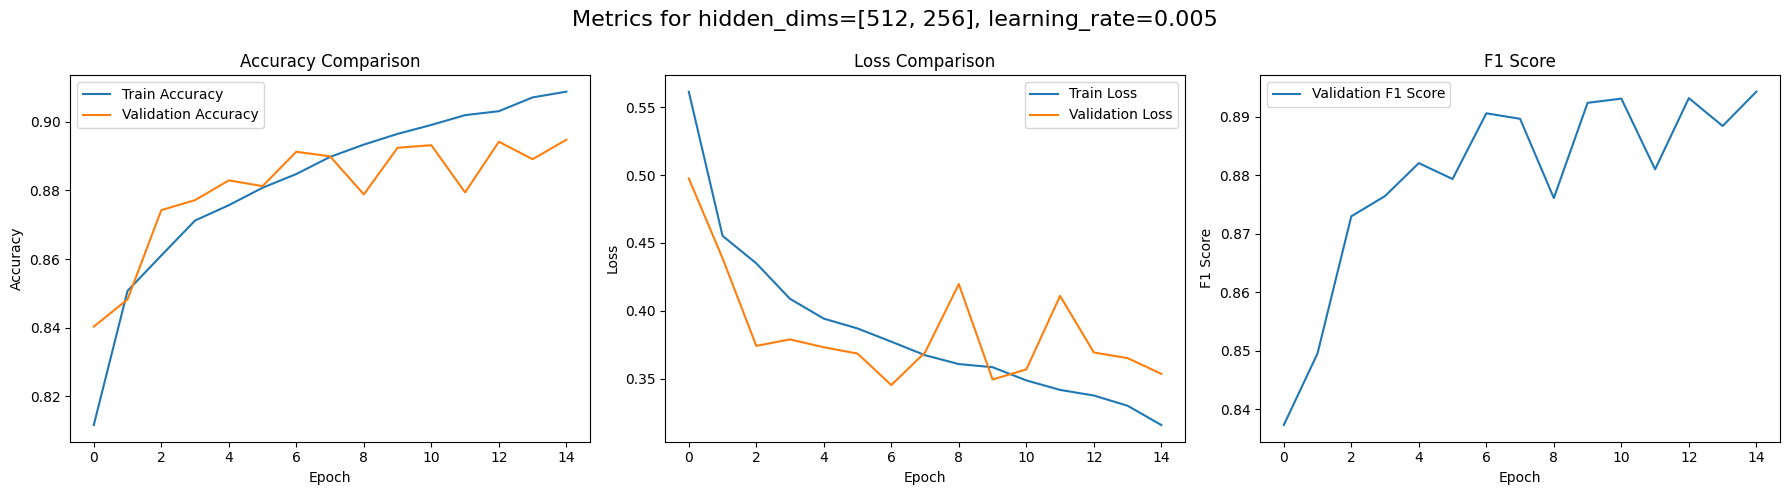

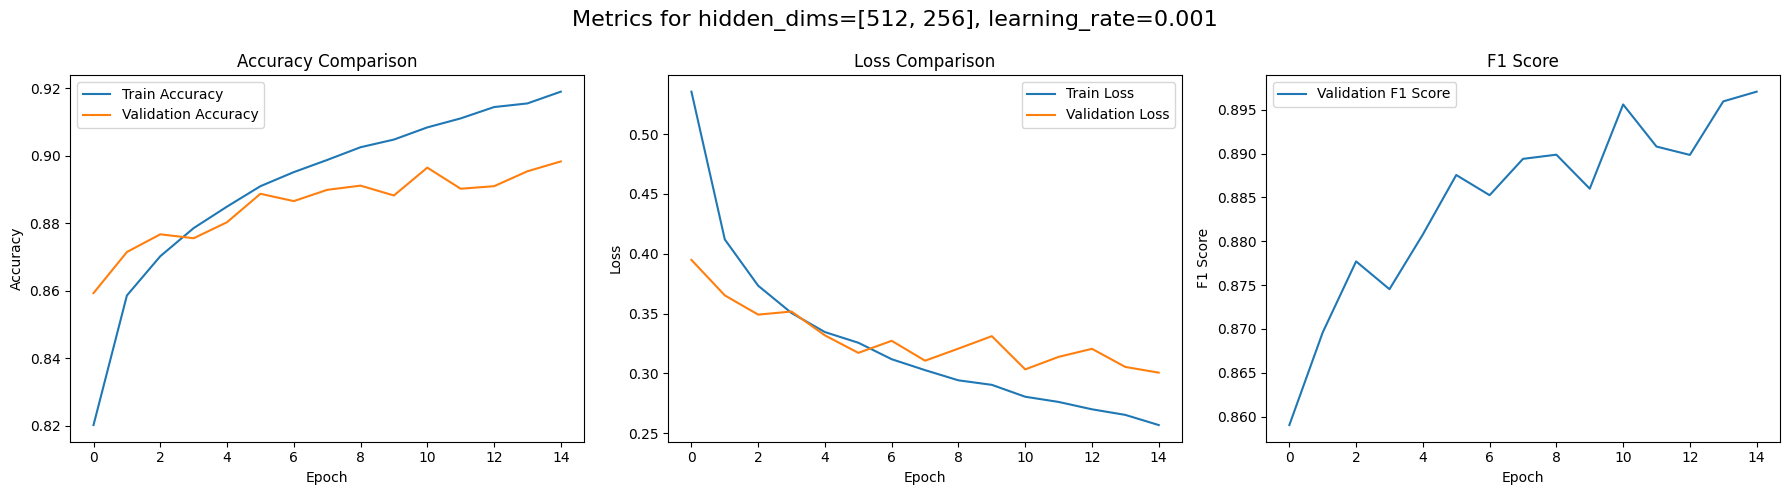

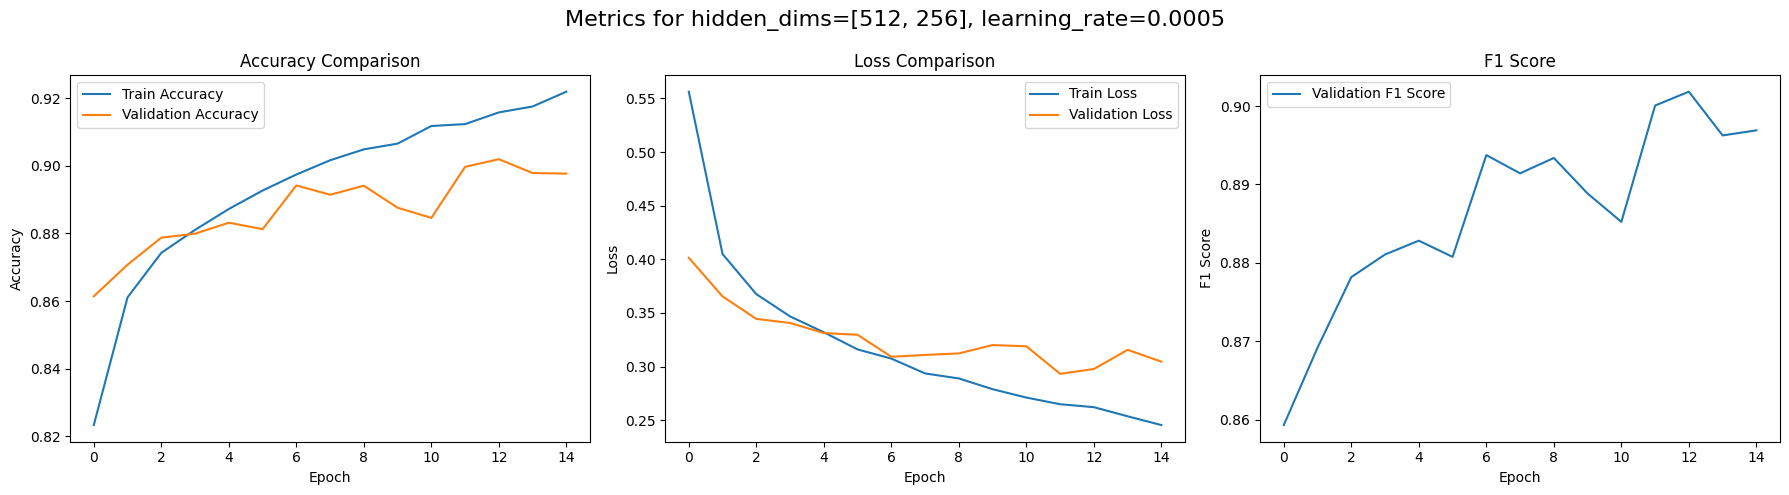

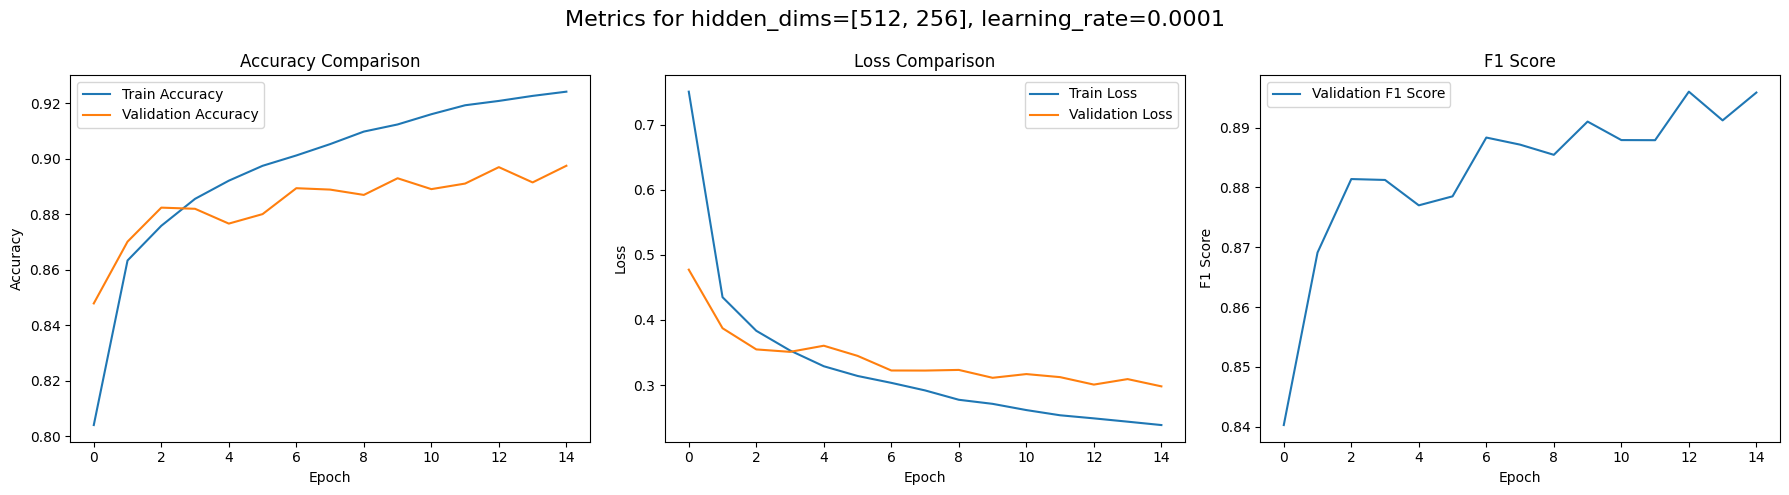

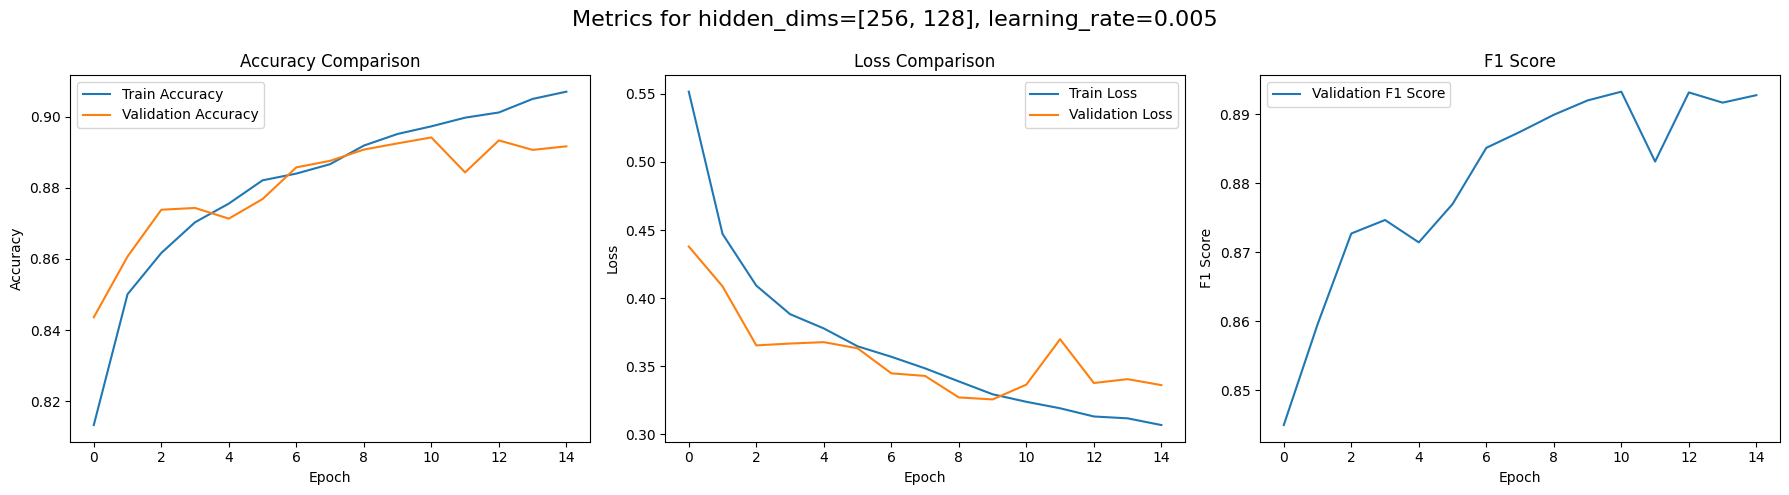

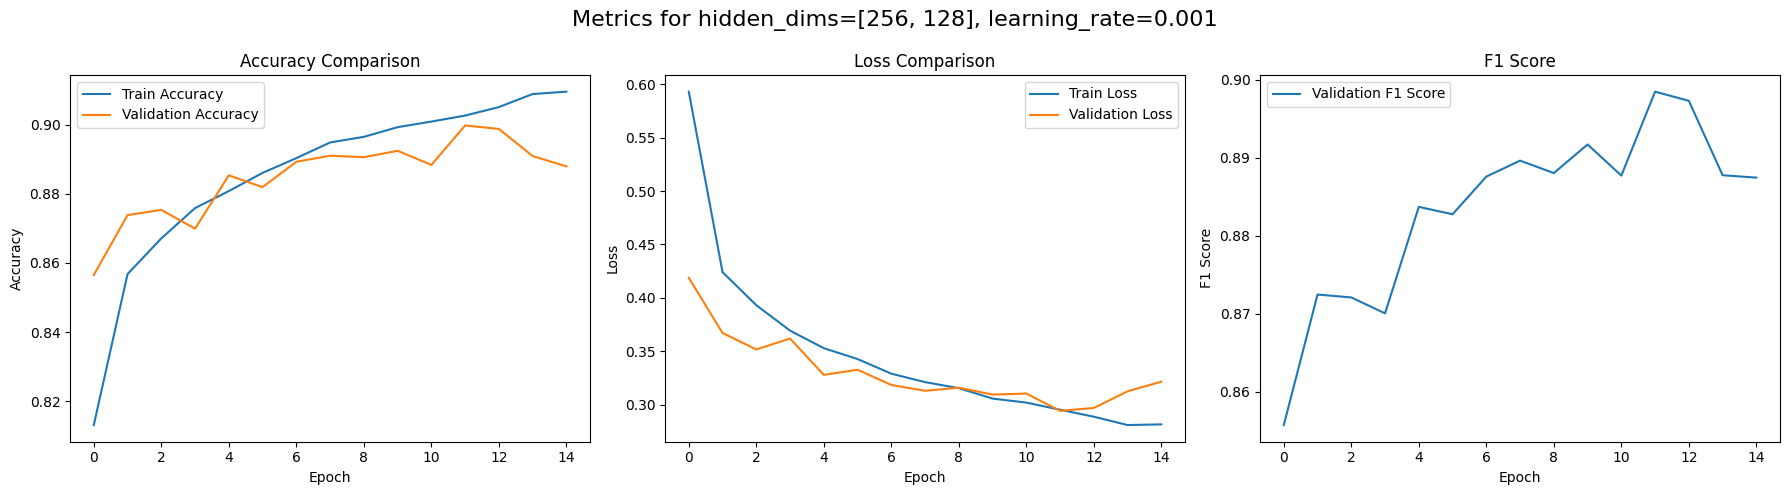

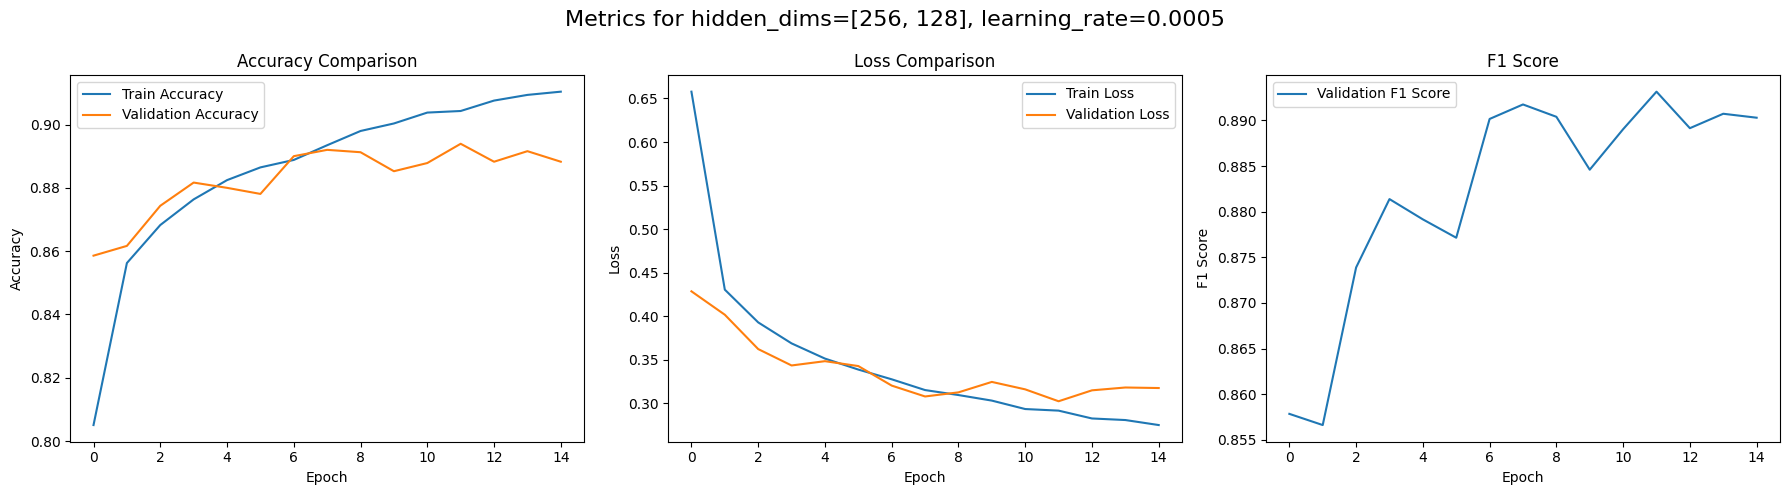

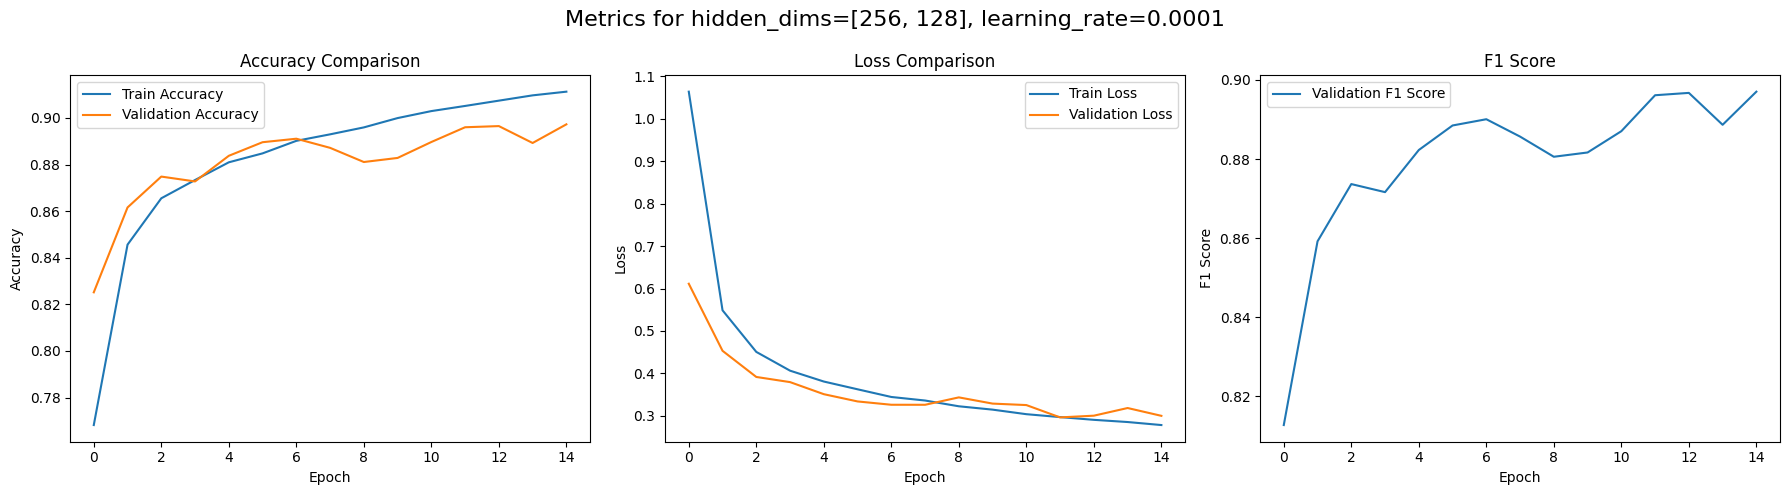

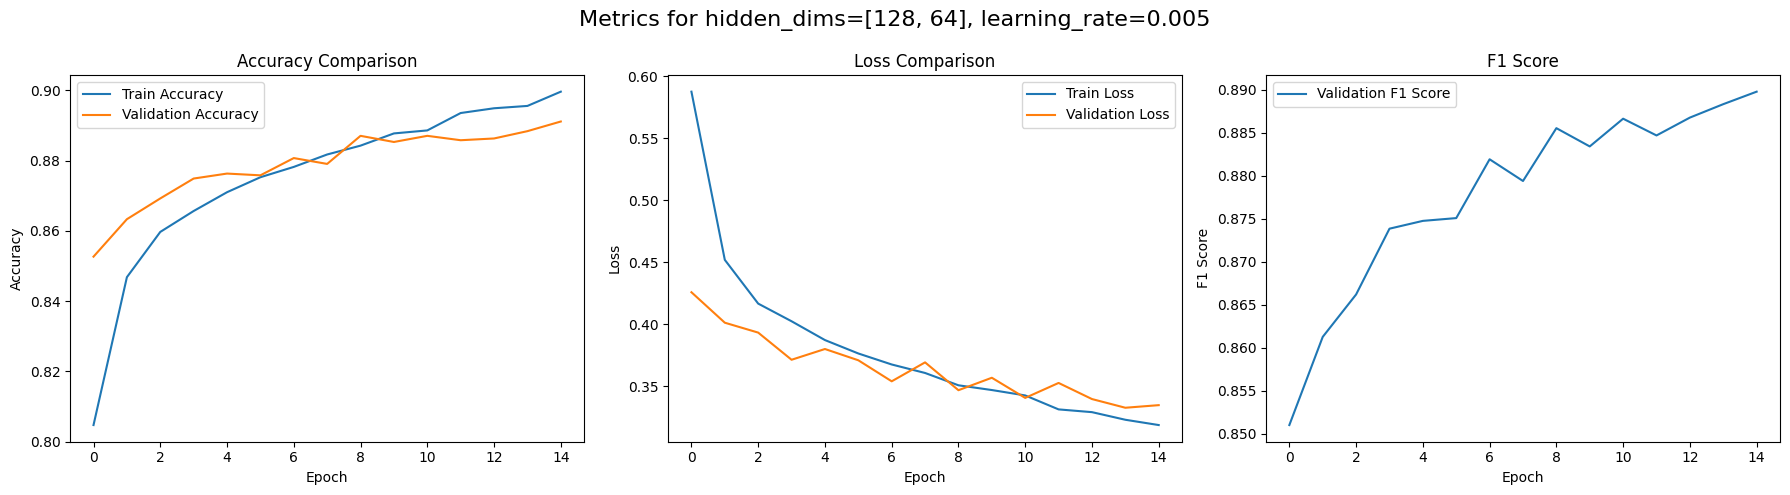

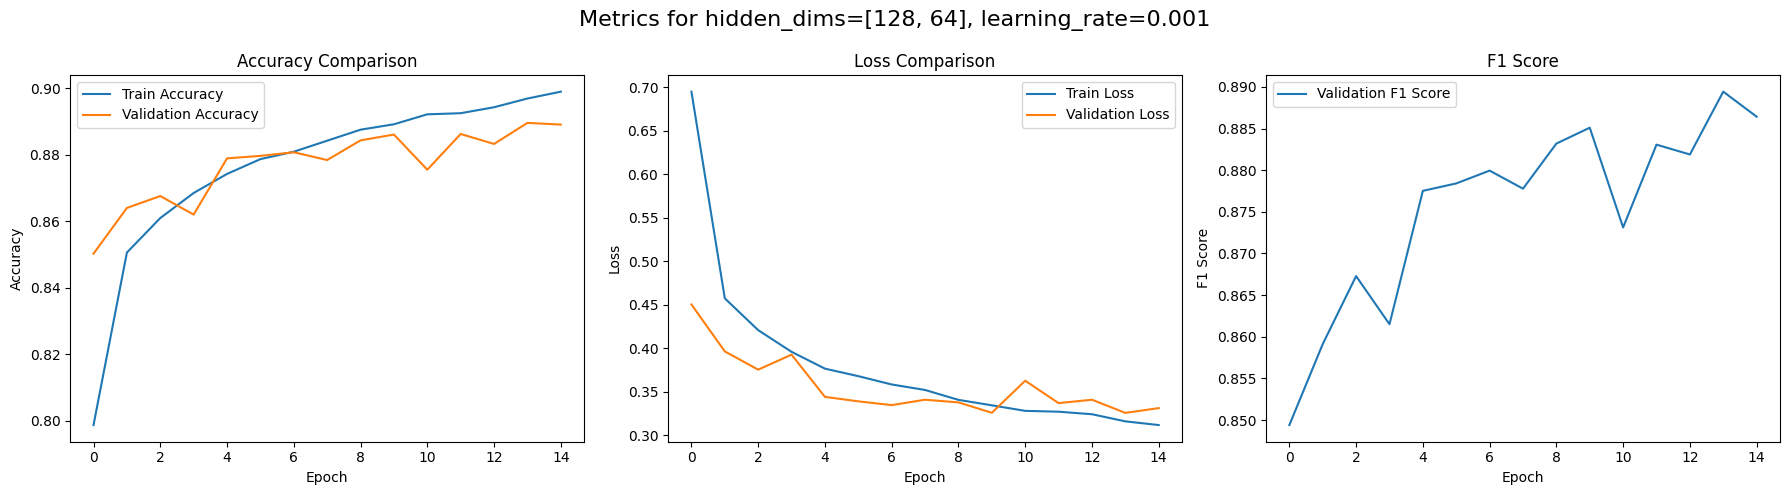

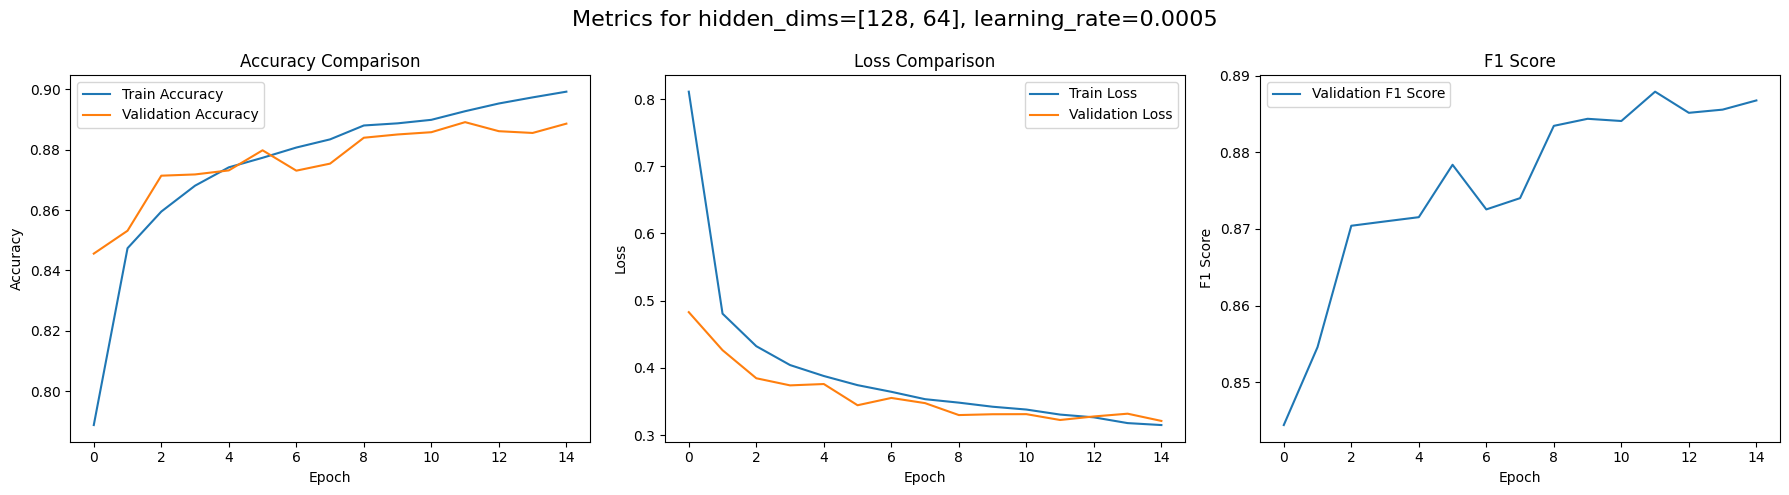

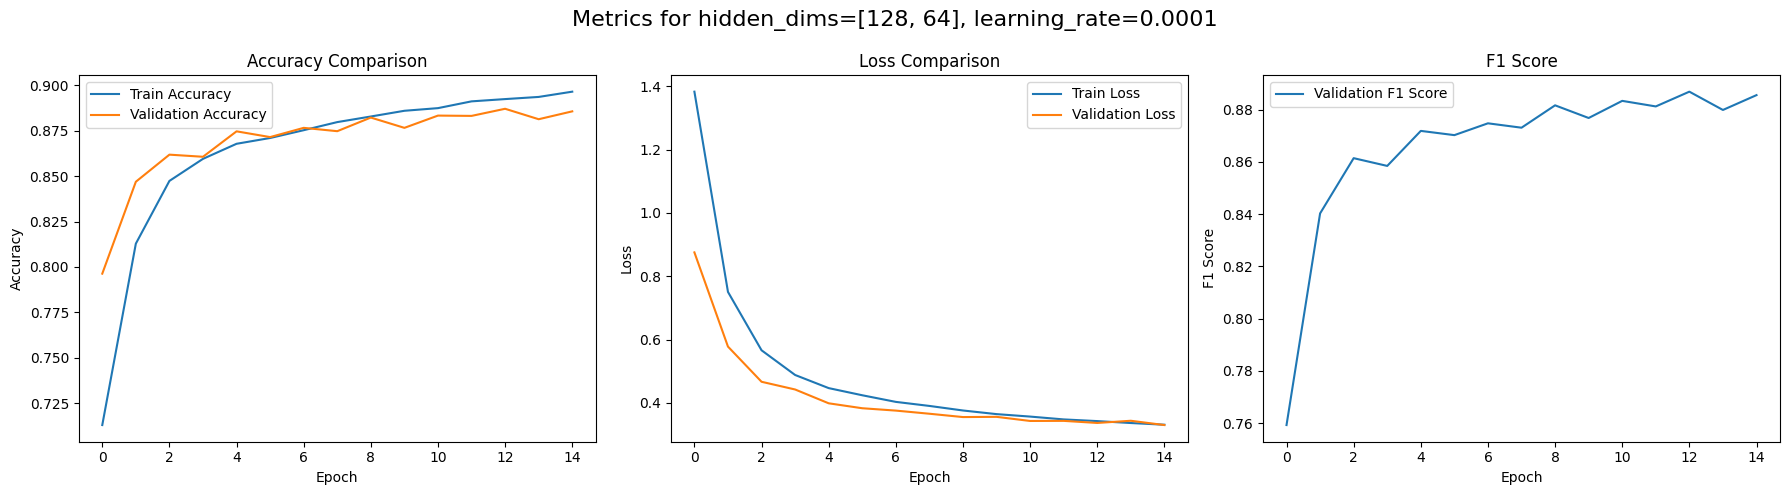

In [95]:
print(histories)
import matplotlib.pyplot as plt
# Function to plot training history
import matplotlib.pyplot as plt

# Function to plot training history
def plot_metrics(history, title="Training and Validation Metrics"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Create a 1x3 grid of subplots

    # Plot for Accuracy
    axes[0].plot(history['train_acc'], label='Train Accuracy')
    axes[0].plot(history['val_acc'], label='Validation Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Accuracy Comparison')
    axes[0].legend()

    # Plot for Loss
    axes[1].plot(history['train_loss'], label='Train Loss')
    axes[1].plot(history['val_loss'], label='Validation Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Loss Comparison')
    axes[1].legend()

    # Plot for F1 Score
    axes[2].plot(history['val_f1'], label='Validation F1 Score')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('F1 Score')
    axes[2].set_title('F1 Score')
    axes[2].legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust the title to fit
    plt.show()


for history in histories:
    plot_metrics(history, title=f"Metrics for hidden_dims={history['model_info'][0]}, learning_rate={history['model_info'][1]}")

In [96]:
# Function to plot training history
def plot_all(histories, title="Training and Validation Metrics",info_model=True):
    fig, axes = plt.subplots(1, 5, figsize=(18, 5))  # Create a 1x3 grid of subplots

    for history in histories:
        if info_model:
            axes[0].plot(history['train_acc'], label=f'{history['model_info'][0]}')
        else:
            axes[0].plot(history['train_acc'], label=f'{history['model_info'][1]}')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Train Accuracy')
    axes[0].set_title('Train Accuracy Comparison')
    axes[0].legend()

    for history in histories:
        if info_model:
            axes[1].plot(history['train_loss'], label=f'{history['model_info'][0]}')
        else:
            axes[1].plot(history['train_loss'], label=f'{history['model_info'][1]}')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Train Loss')
    axes[1].set_title('Train Loss Comparison')
    axes[1].legend()

    for history in histories:
        if info_model:
            axes[2].plot(history['val_acc'], label=f'{history['model_info'][0]}')
        else:
            axes[2].plot(history['val_acc'], label=f'{history['model_info'][1]}')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Validation Accuracy')
    axes[2].set_title('Validation Accuracy Comparison')
    axes[2].legend()

    for history in histories:
        if info_model:
            axes[3].plot(history['val_loss'], label=f'{history['model_info'][0]}')
        else:
            axes[3].plot(history['val_loss'], label=f'{history['model_info'][1]}')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('Validation Loss')
    axes[3].set_title('Validation Loss Comparison')
    axes[3].legend()

    for history in histories:
        if info_model:
            axes[4].plot(history['val_f1'], label=f'{history['model_info'][0]}')
        else:
            axes[4].plot(history['val_f1'], label=f'{history['model_info'][1]}')
    axes[4].set_xlabel('Epoch')
    axes[4].set_ylabel('Validation F1 Score')
    axes[4].set_title('Validation F1 Score Comparison')
    axes[4].legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust the title to fit
    plt.show()

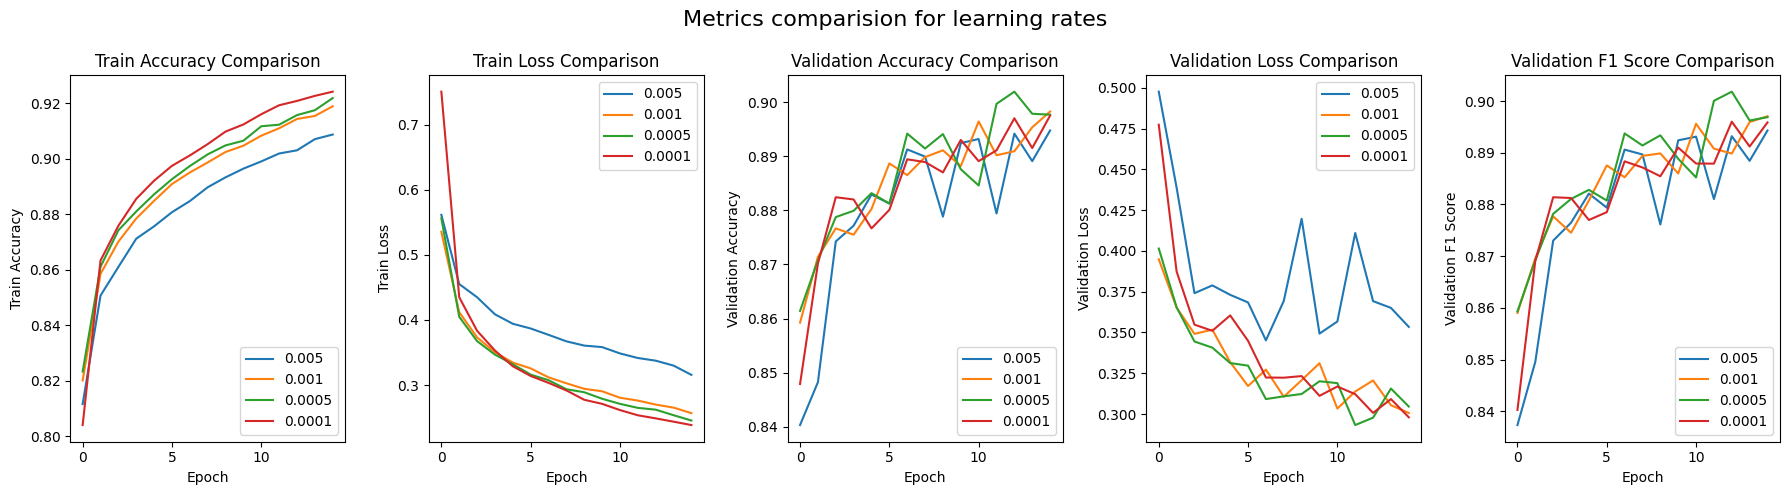

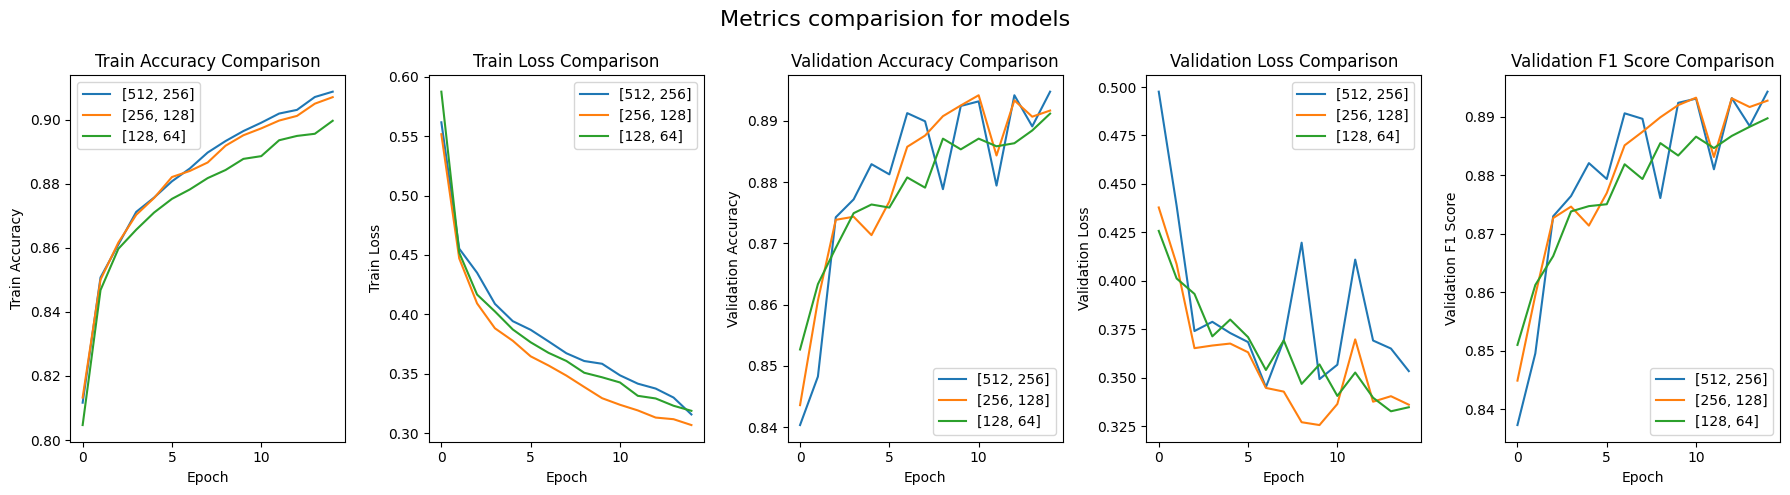

In [97]:
specific_history = histories[:len(learning_rates)]
plot_all(specific_history, title=f"Metrics comparision for learning rates",info_model=False)

specific_history = histories[0::len(learning_rates)] 
plot_all(specific_history, title=f"Metrics comparision for models",info_model=True)

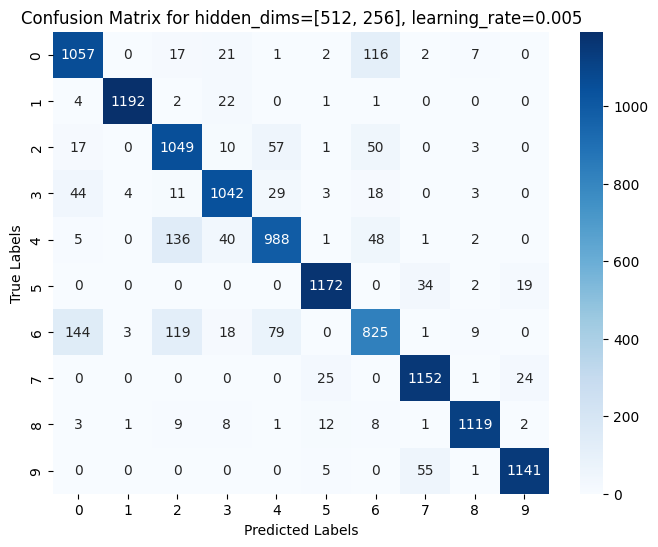

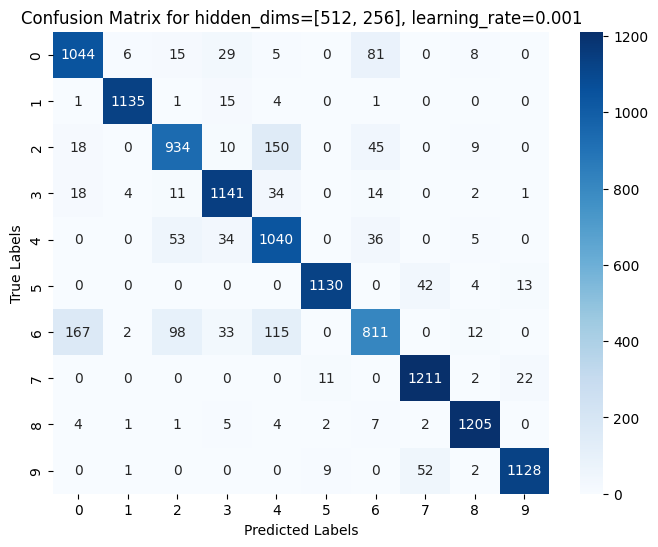

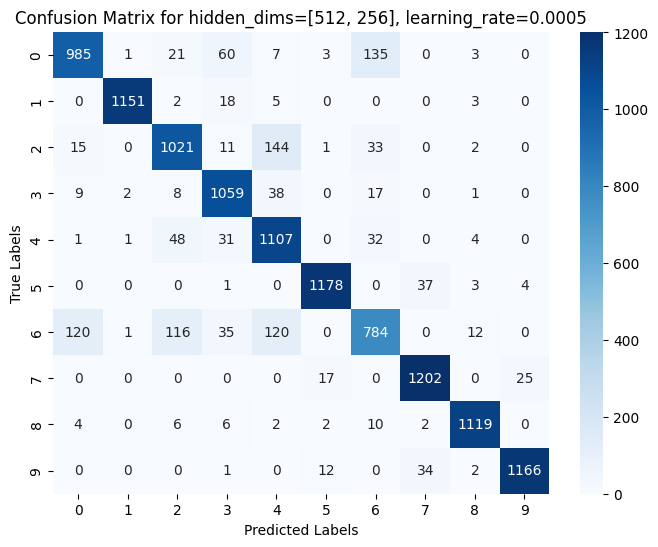

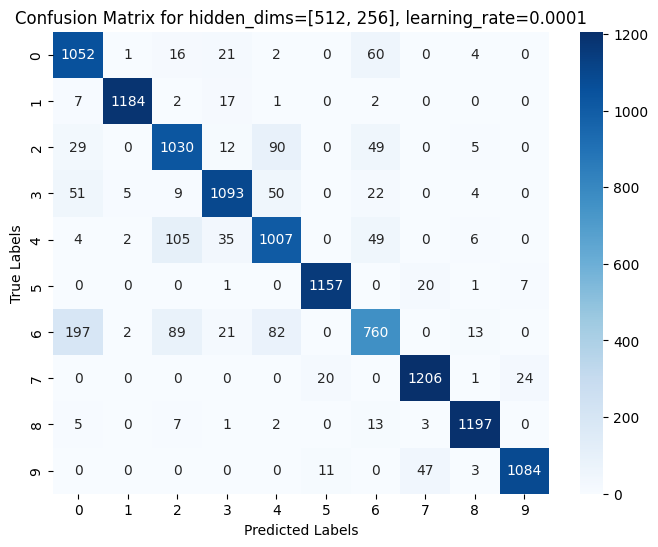

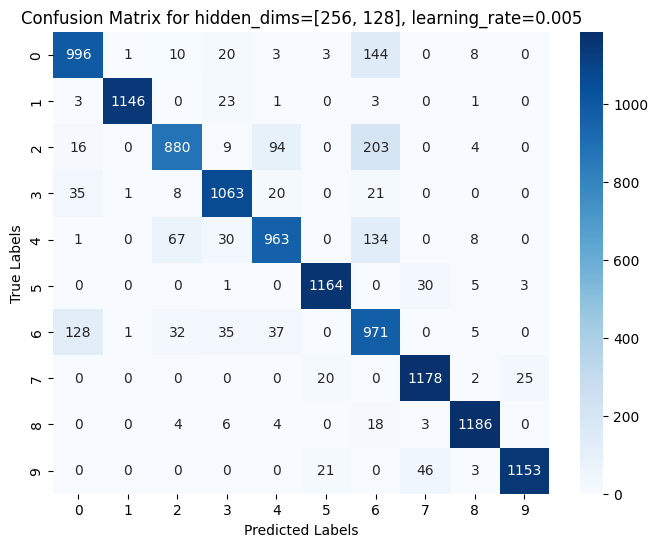

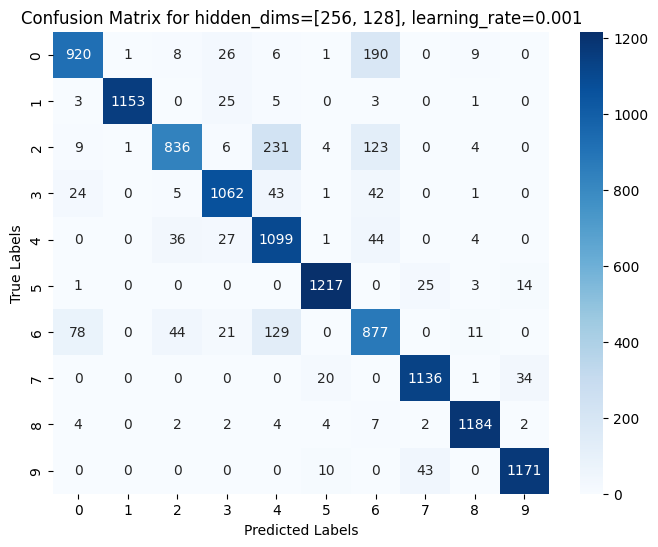

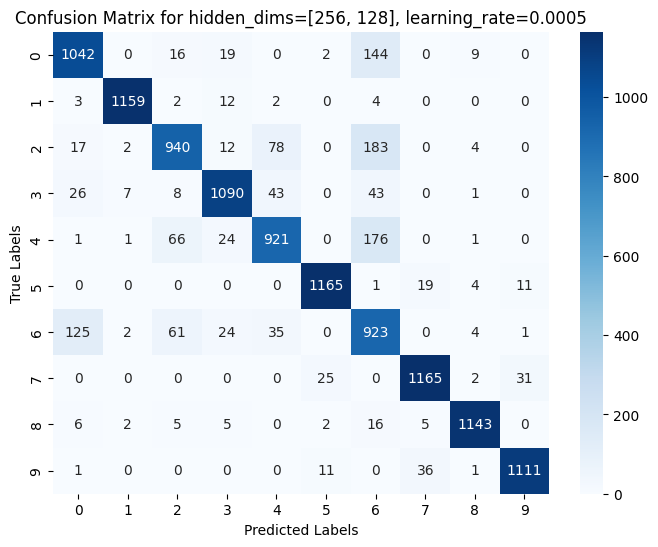

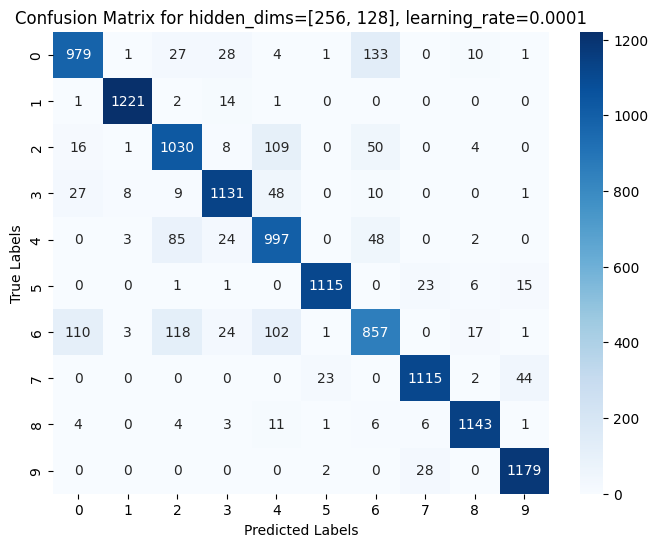

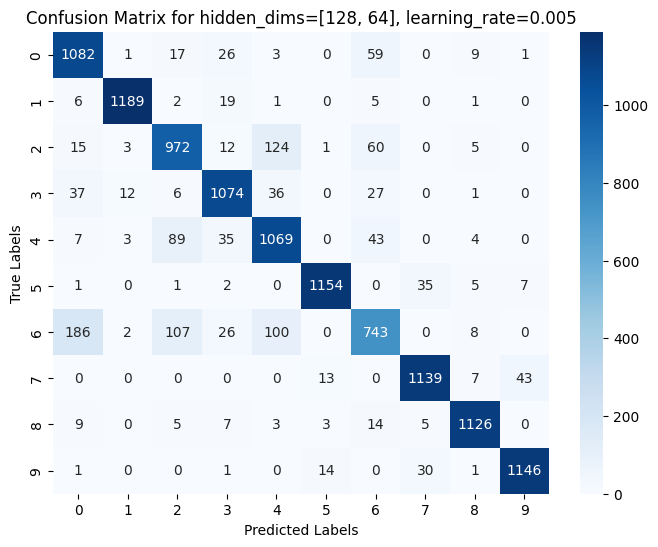

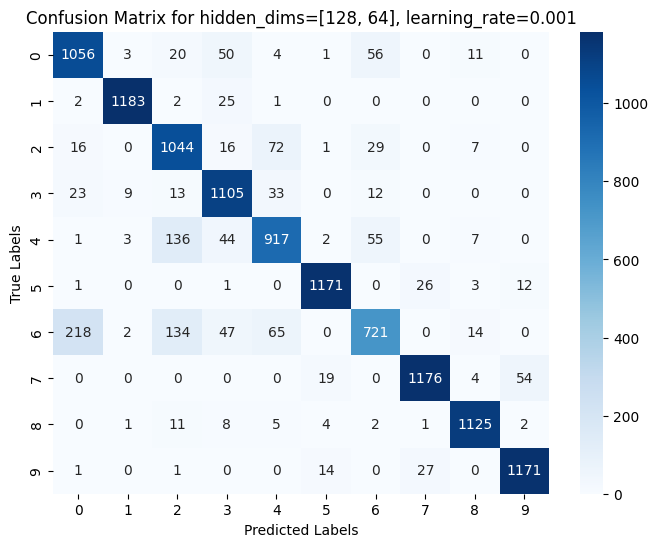

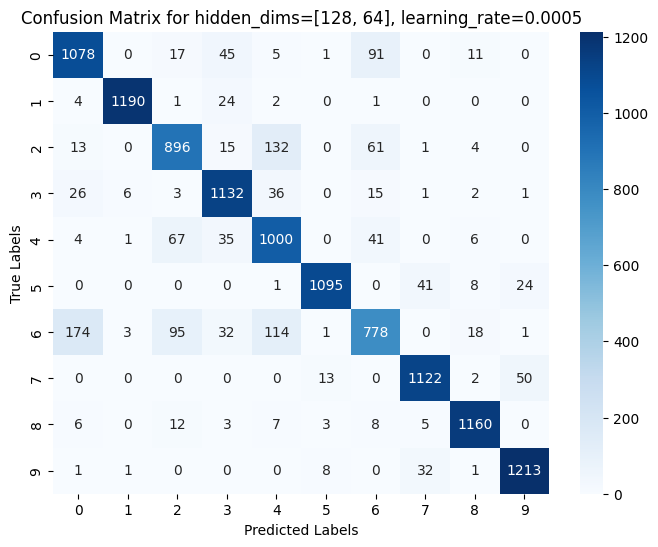

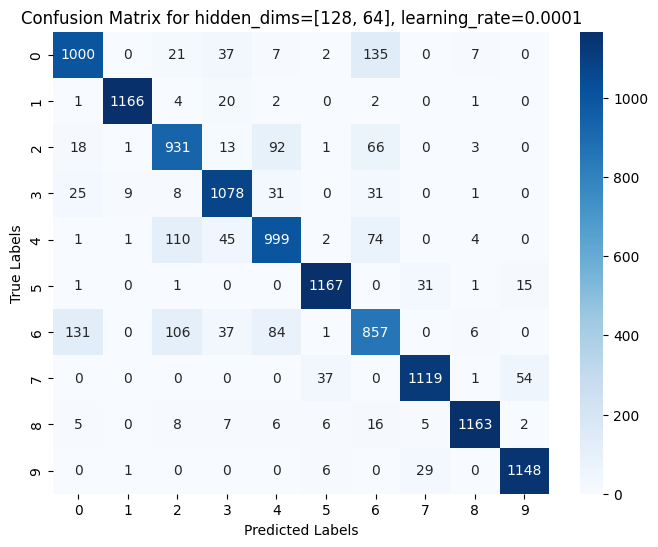

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

for history in histories:
    # Plotting the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(history['confusion_mat'][0], annot=True, fmt="d", cmap="Blues", xticklabels=range(output_dim), yticklabels=range(output_dim))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for hidden_dims={history['model_info'][0]}, learning_rate={history['model_info'][1]}')
    plt.show()

In [118]:
import pandas as pd

# Set global display format to 4 decimal places
pd.options.display.float_format = '{:.4f}'.format

for history in histories:
    print(f"\nfor hidden_dims={history['model_info'][0]}, learning_rate={history['model_info'][1]}:")
    mat = []
    for i in range(len(history['train_loss'])):
        arr = []
        arr.append(i+1)
        arr.append(history['train_loss'][i])
        arr.append(history['train_acc'][i])
        arr.append(history['val_loss'][i])
        arr.append(history['val_acc'][i])
        arr.append(history['val_f1'][i])
        mat.append(arr)
      
    df = pd.DataFrame(mat, columns=['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc','val_f1'])
    print(df.to_string(index=False))



for hidden_dims=[512, 256], learning_rate=0.005:
 epoch  train_loss  train_acc  val_loss  val_acc  val_f1
     1      0.5616     0.8117    0.4976   0.8403  0.8373
     2      0.4553     0.8508    0.4388   0.8482  0.8496
     3      0.4350     0.8610    0.3741   0.8742  0.8730
     4      0.4088     0.8712    0.3789   0.8772  0.8765
     5      0.3942     0.8757    0.3731   0.8829  0.8821
     6      0.3869     0.8808    0.3684   0.8812  0.8794
     7      0.3772     0.8848    0.3452   0.8912  0.8906
     8      0.3672     0.8898    0.3693   0.8899  0.8897
     9      0.3607     0.8933    0.4197   0.8788  0.8761
    10      0.3583     0.8965    0.3493   0.8924  0.8924
    11      0.3486     0.8991    0.3567   0.8932  0.8931
    12      0.3416     0.9019    0.4110   0.8794  0.8810
    13      0.3375     0.9031    0.3692   0.8942  0.8932
    14      0.3299     0.9071    0.3651   0.8891  0.8884
    15      0.3157     0.9087    0.3534   0.8948  0.8943

for hidden_dims=[512, 256], learning_

In [99]:
max_f1_score = 0
best_history = None

for history in histories:
    print(f'for hidden_dims={history['model_info'][0]}, learning_rate={history['model_info'][1]} f1 score: {history['val_f1'][num_epochs-1]:.4f}')
    if history['val_f1'][num_epochs-1] > max_f1_score:
        max_f1_score = history['val_f1'][num_epochs-1]
        best_history = history

print("\nbest model:")
print(f'for hidden_dims={best_history['model_info'][0]}, learning_rate={best_history['model_info'][1]} f1 score: {best_history['val_f1'][num_epochs-1]:.4f} validation_accuracy: {best_history['val_acc'][num_epochs-1]:.4f}')

for hidden_dims=[512, 256], learning_rate=0.005 f1 score: 0.8943
for hidden_dims=[512, 256], learning_rate=0.001 f1 score: 0.8971
for hidden_dims=[512, 256], learning_rate=0.0005 f1 score: 0.8969
for hidden_dims=[512, 256], learning_rate=0.0001 f1 score: 0.8959
for hidden_dims=[256, 128], learning_rate=0.005 f1 score: 0.8928
for hidden_dims=[256, 128], learning_rate=0.001 f1 score: 0.8874
for hidden_dims=[256, 128], learning_rate=0.0005 f1 score: 0.8903
for hidden_dims=[256, 128], learning_rate=0.0001 f1 score: 0.8970
for hidden_dims=[128, 64], learning_rate=0.005 f1 score: 0.8898
for hidden_dims=[128, 64], learning_rate=0.001 f1 score: 0.8864
for hidden_dims=[128, 64], learning_rate=0.0005 f1 score: 0.8868
for hidden_dims=[128, 64], learning_rate=0.0001 f1 score: 0.8855

best model:
for hidden_dims=[512, 256], learning_rate=0.001 f1 score: 0.8971 validation_accuracy: 0.8982


In [100]:
history_final = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': [], 'model_info':[],'confusion_mat':[]}
history_final['model_info'].append(best_history['model_info'][0])
history_final['model_info'].append(best_history['model_info'][1])

train_loader_full = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model_current = Model(input_dim,best_history['model_info'][0],output_dim,dropout_rate,best_history['model_info'][1],batch_size,num_epochs)
best_model = model_current.fit(train_loader_full,history_final,train=False)

15


  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [01:01<00:00, 15.15it/s]


total:  60000 correct:  49710
Epoch [1/15], Loss: 0.5144, Accuracy: 0.8285


100%|██████████| 938/938 [00:52<00:00, 17.74it/s]


total:  60000 correct:  51899
Epoch [2/15], Loss: 0.3965, Accuracy: 0.8650


100%|██████████| 938/938 [00:50<00:00, 18.58it/s]


total:  60000 correct:  52492
Epoch [3/15], Loss: 0.3649, Accuracy: 0.8749


100%|██████████| 938/938 [00:48<00:00, 19.32it/s]


total:  60000 correct:  52947
Epoch [4/15], Loss: 0.3435, Accuracy: 0.8824


100%|██████████| 938/938 [00:48<00:00, 19.17it/s]


total:  60000 correct:  53300
Epoch [5/15], Loss: 0.3292, Accuracy: 0.8883


100%|██████████| 938/938 [00:47<00:00, 19.63it/s]


total:  60000 correct:  53555
Epoch [6/15], Loss: 0.3175, Accuracy: 0.8926


100%|██████████| 938/938 [00:48<00:00, 19.45it/s]


total:  60000 correct:  53808
Epoch [7/15], Loss: 0.3078, Accuracy: 0.8968


100%|██████████| 938/938 [01:07<00:00, 13.90it/s]


total:  60000 correct:  54021
Epoch [8/15], Loss: 0.2975, Accuracy: 0.9003


100%|██████████| 938/938 [00:52<00:00, 17.84it/s]


total:  60000 correct:  54382
Epoch [9/15], Loss: 0.2853, Accuracy: 0.9064


100%|██████████| 938/938 [00:57<00:00, 16.22it/s]


total:  60000 correct:  54442
Epoch [10/15], Loss: 0.2825, Accuracy: 0.9074


100%|██████████| 938/938 [00:46<00:00, 19.96it/s]


total:  60000 correct:  54571
Epoch [11/15], Loss: 0.2799, Accuracy: 0.9095


100%|██████████| 938/938 [00:43<00:00, 21.38it/s]


total:  60000 correct:  54761
Epoch [12/15], Loss: 0.2720, Accuracy: 0.9127


100%|██████████| 938/938 [00:56<00:00, 16.68it/s]


total:  60000 correct:  54976
Epoch [13/15], Loss: 0.2637, Accuracy: 0.9163


100%|██████████| 938/938 [00:56<00:00, 16.62it/s]


total:  60000 correct:  55034
Epoch [14/15], Loss: 0.2582, Accuracy: 0.9172


100%|██████████| 938/938 [00:53<00:00, 17.58it/s]

total:  60000 correct:  55221
Epoch [15/15], Loss: 0.2548, Accuracy: 0.9204


In [101]:
# DataLoader for testing
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [102]:
Test(best_model,test_loader)

Confusion Matrix:
[[831   2  16  30   3   1 107   0  10   0]
 [  3 973   2  18   1   0   1   0   2   0]
 [ 19   0 852  16  57   0  53   0   3   0]
 [ 24   8   9 908  23   1  23   0   4   0]
 [  0   0 117  39 791   1  50   0   2   0]
 [  1   1   0   1   1 964   0  20   2  10]
 [122   1 114  35  75   1 644   0   8   0]
 [  0   0   0   0   0  37   0 940   0  23]
 [  5   0   2   9   3   5   5   3 968   0]
 [  0   0   0   0   0  16   1  32   0 951]]
Test Accuracy: 88.22%


In [106]:
import pickle

# Save the trained model to a file
with open('1905114.pkl', 'wb') as file:
    pickle.dump(best_model, file)
print("Model saved successfully!")


Model saved successfully!


In [107]:
# Load the model from the file
with open('1905114.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully!")


Model loaded successfully!


In [108]:
Test(loaded_model,test_loader)

Confusion Matrix:
[[839   4  15  28   3   2  99   0  10   0]
 [  8 970   3  15   2   0   1   0   1   0]
 [ 15   1 854  19  61   0  47   0   3   0]
 [ 20   8  10 910  20   0  29   0   2   1]
 [  1   0 116  37 788   1  53   0   4   0]
 [  2   0   0   0   0 971   0  16   2   9]
 [129   2 119  29  69   1 644   0   7   0]
 [  0   0   0   0   0  40   0 938   0  22]
 [  8   1   3   9   2   5   3   5 964   0]
 [  0   0   0   0   0  12   1  34   0 953]]
Test Accuracy: 88.31%
